<a target="_blank" href="https://colab.research.google.com/github/ginal001/ML-2024-2025/blob/main/Lab10/Homework10.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Lab 10 - Convolutional Neural Network, CNN

### Author: Szymon Nowakowski

# Presentation on Convolutional Layers
--------------------

We shall start off by going through a [short presentation on convolusional layers](https://github.com/SzymonNowakowski/Machine-Learning-2024/blob/master/convolutional_layers.pdf). It is best to first download it and then go through it in a slide-show layout.

# Reading MNIST Dataset
----------------------------------

In [1]:
import torch
import torchvision
from matplotlib import pyplot

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

# Tensor Sizes
-------------------

Recall:
- Batched labels are of order one. The first (and only) index is a sample index within a batch.
- Image batches have order 4. The first order is a batch order, but a second order has dimensionality of 1 and thus it can be indexed by 0 only.
  - This index represents a Channel number inserted here by `ToTensor()` transformation, always 0.
  - This singleton order should be retained because we want to use convolutional layers, which explicitly require this order. For RGB images we have 3 channels, for B&W images we have only one channel.


# CNN Definition
-----------------



## Task

Your job now is to code the definition of the LeNet5 neural network. You can find the definition [here](https://en.wikipedia.org/wiki/LeNet#/media/File:Comparison_image_neural_networks.svg).


In [2]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.nn.ReLU()
        self.conv1 = torch.nn.Conv2d(kernel_size = 5, in_channels = 1, out_channels = 6)
        self.conv2 = torch.nn.Conv2d(kernel_size = 5, in_channels = 6, out_channels = 16)
        self.conv3 = torch.nn.Conv2d(kernel_size = 4, in_channels = 16, out_channels = 120)
        self.pool = nn.AvgPool2d(kernel_size = 2, stride = 2)
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(120, 84)
        self.linear2 = torch.nn.Linear(84, 10)
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x): # B, 1, 28, 28
        x = self.relu(self.conv1(x)) # B, 6, 24, 24
        x = self.pool(x) # B, 6, 12, 12
        x = self.relu(self.conv2(x)) # B, 16, 8, 8
        x = self.pool(x)  # B, 16, 4, 4
        x = self.relu(self.conv3(x)) # B, 120, 1, 1
        x = x.squeeze(-1).squeeze(-1) #B, 120
        x = F.relu(self.linear1(x)) #B, 84
        x = self.linear2(x) #B, 84
        x = self.dropout(x)
        return x

# Training Loop
----------------------

In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = LeNet5().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(16):  #  an epoch is a training run through the whole data set

    loss = 0.0
    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the LeNet5 object. Please note,
                                            # the nonlinear activation after the last layer is NOT applied
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cuda
epoch: 0 batch: 0 current batch loss: 2.305403232574463
epoch: 0 batch: 1 current batch loss: 2.296248197555542
epoch: 0 batch: 2 current batch loss: 2.2860145568847656
epoch: 0 batch: 3 current batch loss: 2.27335262298584
epoch: 0 batch: 4 current batch loss: 2.2617902755737305
epoch: 0 batch: 5 current batch loss: 2.242074489593506
epoch: 0 batch: 6 current batch loss: 2.2223219871520996
epoch: 0 batch: 7 current batch loss: 2.196256160736084
epoch: 0 batch: 8 current batch loss: 2.163954973220825
epoch: 0 batch: 9 current batch loss: 2.1264281272888184
epoch: 0 batch: 10 current batch loss: 2.0909371376037598
epoch: 0 batch: 11 current batch loss: 2.0381596088409424
epoch: 0 batch: 12 current batch loss: 1.9810428619384766
epoch: 0 batch: 13 current batch loss: 1.9111250638961792
epoch: 0 batch: 14 current batch loss: 1.8516062498092651
epoch: 0 batch: 15 current batch loss: 1.7767876386642456
epoch: 0 batch: 16 current batch loss: 1.6987053155899048
epoch: 0 batch:

# Testing
----------------------

In [4]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9806


# Understanding Kernel Size, Stride and Padding

## Task: Designing a Convolutional Neural Network with a Target Receptive Field

Design a convolutional neural network using only 3×3 or 5×5 convolutional layers and 2×2 max-pooling layers without overlap (i.e., with stride 2). Use no padding in any layer. Insert a max-pooling layer after every two or three convolutional layers.

Your goal is to construct an architecture such that the receptive field of each output neuron is approximately 60×60 pixels.

Compute the receptive field size of the final output layer.

Compute the effective stride of the output layer with respect to the input.

Assuming an input image size of 400×400, determine the spatial size of the output feature map.

Q: Where would you locate ReLU layers?
Q: What if we can't match the desired input size with our architecture?
Q: Discuss what possible impact padding can have on the network performance.



# **Homework Assignment – Adversarial Examples**

In this assignment, you will explore how small (invisible to humans) changes to real digits can _fool_ the CNN into misclassifying them, even though the changes are imperceptible to humans.



## Task 1 – CNN Dreams: Last Homework Assignment Revisited

Re-run the input optimization process (for NN dreams) from the previous MLP-class homework assignment, but this time using the **LeNet-5 CNN model** we trained in this class.


1. Starting from ten random noise images, optimize the input so that each image is classified with high confidence as one of the digits 0 through 9.
2. Include an **L2 penalty** on the input to keep the images visually closer to realistic digits. Use a range of penalty strengths (e.g., $\lambda_{l2}$ = 0, and then 0.01 through 10.0).
3. Compare the generated images (with and without L2 penalty) to those generated by the MLP:
   - Are they more or less readable?
   - Do they resemble real MNIST digits more closely or less?
   - Why do you think that happens? Consider the CNN’s inductive biases and architectural properties.

Use `cross_entropy_loss + lambda_l2 * input.pow(2).mean()` as your objective.

Reuse your code: visualize confidence evolution during optimization and generate image grids and (optionally) animations showing how the inputs evolve.


## Task 2 – Adversarial Examples: Fooling LeNet-5

This is the core focus of the assignment.

Using a batch of **real MNIST digits** (e.g., nine examples per class), craft **adversarial examples** by adding subtle, trained noise to the input images. Your goal is to:

- **Keep the human-perceived digit the same** (e.g., a "7" should still look like a "7"),
- But **cause LeNet-5 to misclassify it** – as every other class different from the original, hence nine examples per class.

### Objective
For each image $x$ and its true label $y$, learn a perturbation $\delta$ such that:

- $\text{LeNet5}(x + \delta) = y_{\text{wrong}} $,
- and $ \|\delta\|_2 $ is as small as possible (penalize large perturbations), to keep $x + \delta$ *look* like $x$ for humans.

### Optimization
Use gradient-based optimization on $\delta$ (the noise), while keeping the network weights frozen. Your loss might look like:

```
loss = cross_entropy(model(x + delta), target_wrong_class) +
       lambda_l2 * delta.pow(2).mean()
```

Tune the $\lambda_{l2}$ to find the best range.

### Deliverables for the Second Task
- Select some best examples, showing the original digit and its (correct) classification and the perturbed digit (hopefully, still looking the same to humans) and how it gets misclassified. Show them side by side.
- Report:
  - Success rate of attacks (it doesn't need to be very formal),
  - Effect of $\lambda_{l2}$ on visibility of the noise and success of misclassification,
  - Example image grids and confidence plots.



## Deliverables for the Homework Assignment
- A Google Colab notebook with:
  - Complete implementation for both tasks.
  - Visualizations and animations (animations are optional but encouraged).
  - Clear written analysis of your findings.
- Upload the notebook and results to your GitHub repository for the course.
- Include a link to the notebook and video (if applicable) in the `README.md`.
- In the notebook, include “Open in Colab” badge so it can be launched directly.

# Solution 

# Task 1

Let's solve task 1. We are going to use the same function as in homework 9. We are going to do exactly the same thing but with different model.

In [5]:
def plot_numbers(points):   #function for plotting trained points
    
    fig, axes = pyplot.subplots(1, 10, figsize=(15, 3))

    for i, ax in enumerate(axes):
        img = points[i].squeeze().detach().cpu().numpy()
        ax.imshow(img)      
        ax.set_title(f"{i}")            
        ax.axis('off')             

    pyplot.tight_layout()
    pyplot.show()



def train_input(net, lambda_l2 = 0, lr = 0.001, prob = 0.99999, plot = False, info = 2000, max_iter = 40000):   # main function
    
    net.eval()
    for parameters in net.parameters():
        parameters.requires_grad = False   # freezing model
    
    points = torch.randn(10, 1, 28, 28).to(device)
    points.requires_grad = True
    true = torch.LongTensor(range(0,10)).to(device)   # defining random noise and output
    
    optimizer = torch.optim.Adam([points], lr)

    epoch = 0
    
    while ( not all([torch.max(torch.nn.functional.softmax(net(points[number]).reshape(1, 10), dim = 1)) > prob for number in range(0,10)]) ) and (epoch < max_iter):
    
        optimizer.zero_grad()
        preds = net(points)   
        loss = torch.nn.functional.cross_entropy(preds, true, reduction = "mean") + lambda_l2 * points.pow(2).mean()
    
        epoch += 1
        if epoch % info == 0:
            with torch.no_grad():
                print("Iteration", epoch, "current batch loss:", loss.item())
                print("Predicted value: ", [torch.argmax(torch.nn.functional.softmax(net(points[number]).reshape(1, 10), dim = 1)).item() for number in range(0,10)], "\n", 
                  "Predicted probability: ", [round(torch.max(torch.nn.functional.softmax(net(points[number]).reshape(1, 10), dim = 1)).item(), 6) for number in range(0,10)])
                if plot:
                    plot_numbers(points)
        
        loss.backward()     
        optimizer.step()     

    print("Iteration", epoch, "current batch loss:", loss.item())
    
    for parameters in net.parameters():
        parameters.requires_grad = True  # unfreezing model
        
    return points

# $\lambda = 0$

Iteration 2000 current batch loss: 0.010161818005144596
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.976027, 0.979435, 0.995699, 0.996207, 0.992081, 0.991928, 0.993098, 0.992463, 0.998231, 0.983983]


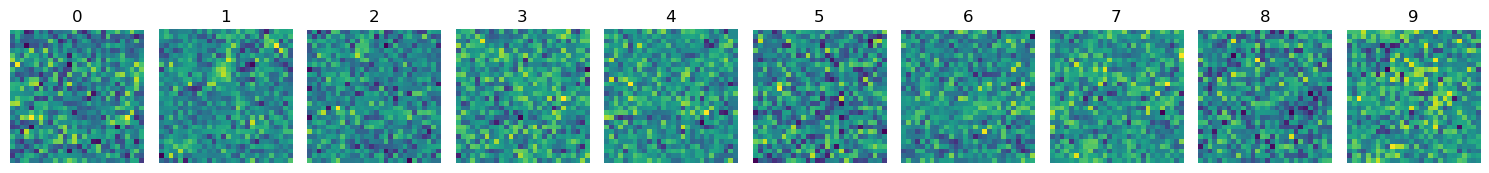

Iteration 4000 current batch loss: 0.002391260815784335
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.994227, 0.994691, 0.998963, 0.999057, 0.998258, 0.998259, 0.998438, 0.998429, 0.999564, 0.996248]


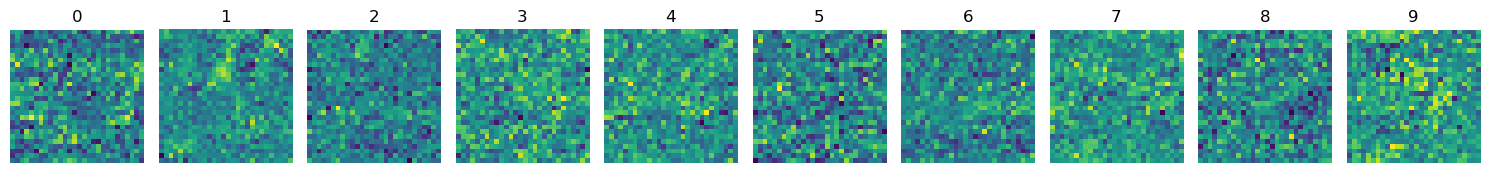

Iteration 6000 current batch loss: 0.0007811652030795813
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.998183, 0.998127, 0.999674, 0.999673, 0.999433, 0.999347, 0.999499, 0.999532, 0.999857, 0.998869]


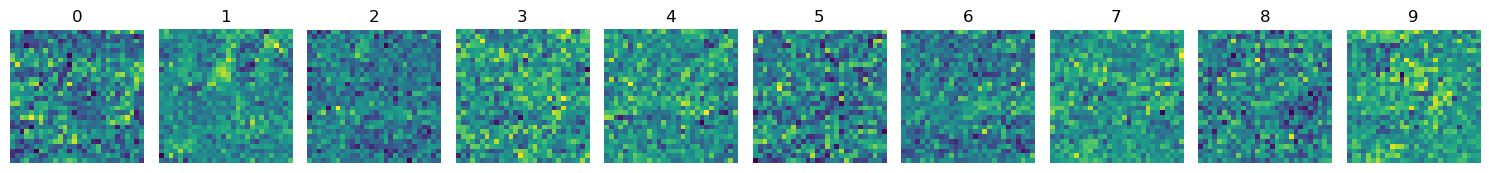

Iteration 8000 current batch loss: 0.0002792226732708514
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999372, 0.999305, 0.999887, 0.999882, 0.999798, 0.999743, 0.999815, 0.999835, 0.999948, 0.999622]


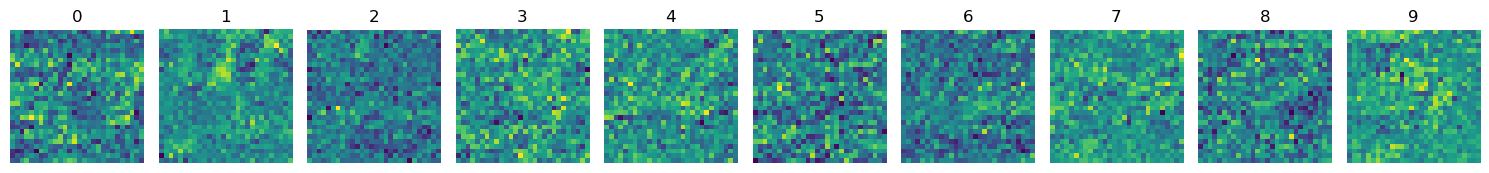

Iteration 10000 current batch loss: 0.00010146282147616148
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999776, 0.999737, 0.99996, 0.999957, 0.999925, 0.999903, 0.99993, 0.999944, 0.999981, 0.999873]


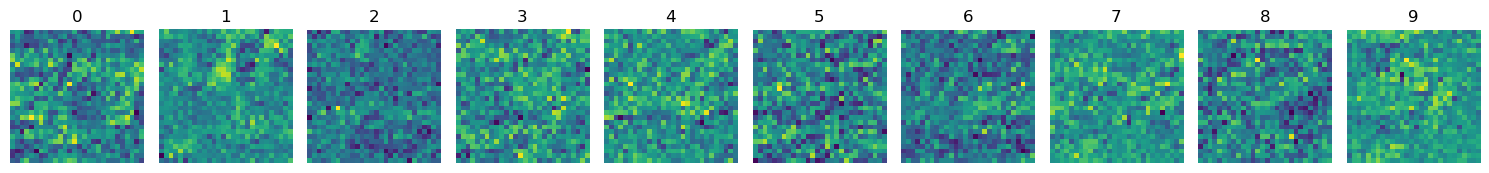

Iteration 12000 current batch loss: 3.721603934536688e-05
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99992, 0.999901, 0.999986, 0.999984, 0.999971, 0.999964, 0.999975, 0.999979, 0.999993, 0.999955]


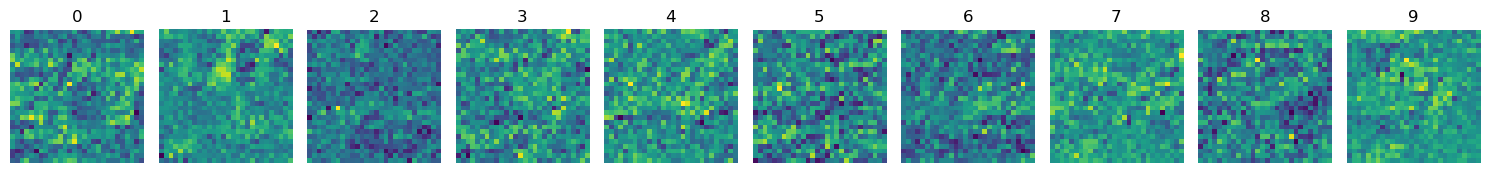

Iteration 14000 current batch loss: 1.3577790923591238e-05
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999973, 0.999962, 0.999995, 0.999994, 0.999989, 0.999987, 0.999991, 0.999992, 0.999998, 0.999984]


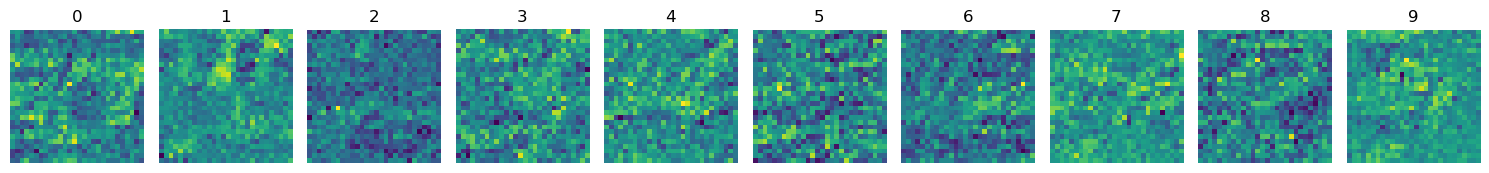

Iteration 16000 current batch loss: 4.97100791108096e-06
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99999, 0.999986, 0.999998, 0.999998, 0.999996, 0.999995, 0.999997, 0.999997, 0.999999, 0.999994]


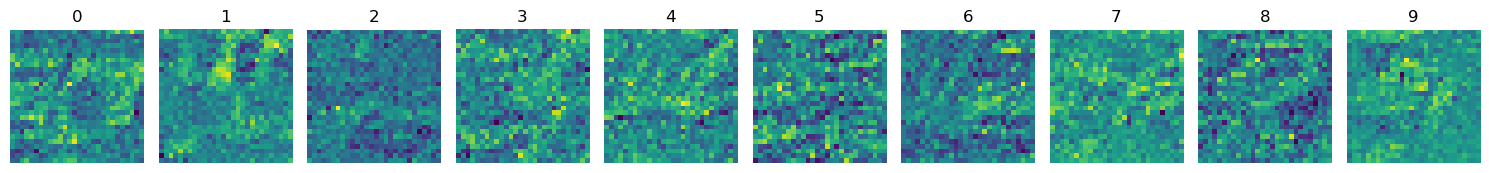

Iteration 16732 current batch loss: 3.4928223158203764e-06


In [6]:
points_1 = train_input(net, plot = True)

# $\lambda = 0.01$

Iteration 2000 current batch loss: 0.022314827889204025
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.980031, 0.97245, 0.996676, 0.993654, 0.990451, 0.992348, 0.987069, 0.990821, 0.994511, 0.981241]


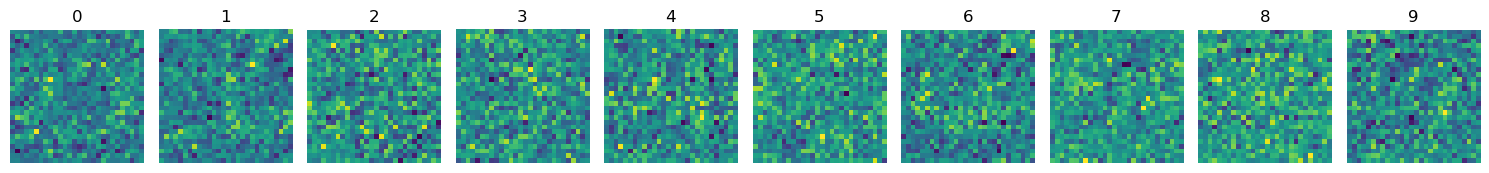

Iteration 4000 current batch loss: 0.012624332681298256
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.994561, 0.99391, 0.999135, 0.998341, 0.997413, 0.998085, 0.996592, 0.997854, 0.998347, 0.995034]


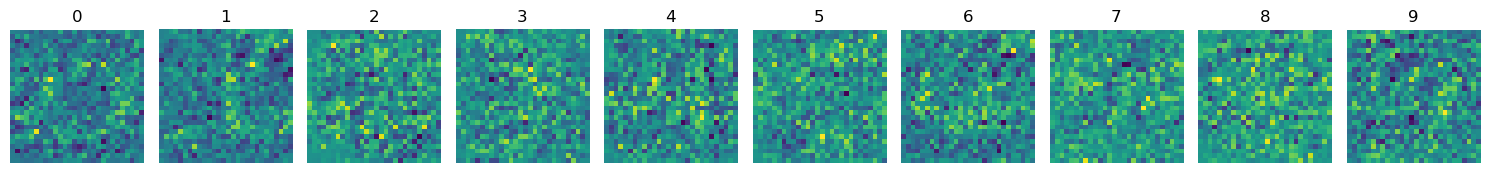

Iteration 6000 current batch loss: 0.009470869787037373
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997797, 0.997749, 0.999537, 0.999334, 0.998935, 0.999207, 0.998714, 0.999149, 0.99926, 0.998011]


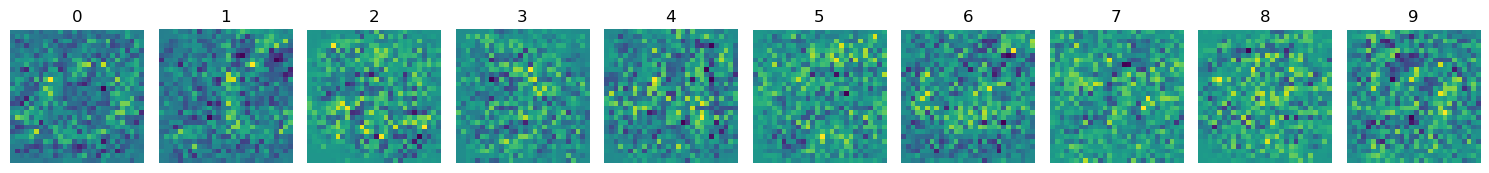

Iteration 8000 current batch loss: 0.007023673504590988
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.998826, 0.998897, 0.99965, 0.999614, 0.99938, 0.999526, 0.999321, 0.999523, 0.999522, 0.999012]


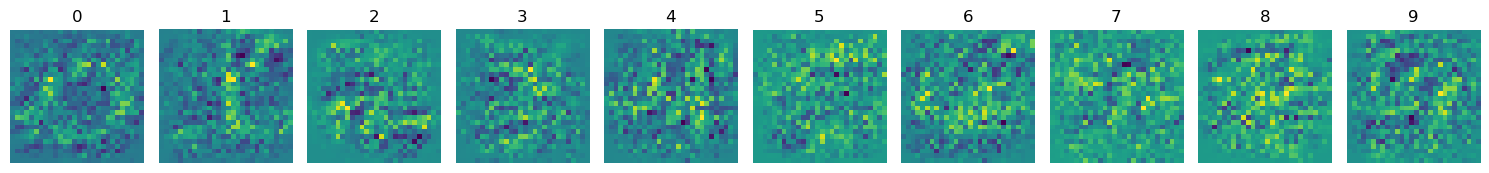

Iteration 10000 current batch loss: 0.004773396532982588
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999189, 0.999257, 0.999713, 0.999683, 0.999576, 0.999653, 0.999505, 0.999641, 0.99961, 0.999347]


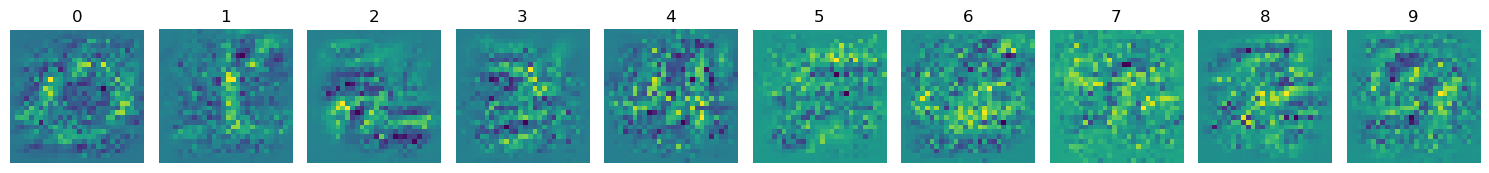

Iteration 12000 current batch loss: 0.0030526781920343637
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999338, 0.999423, 0.999756, 0.999714, 0.999682, 0.999698, 0.999546, 0.999685, 0.999656, 0.999468]


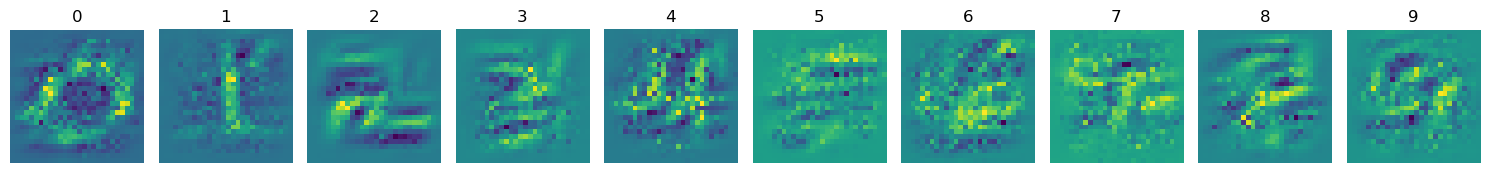

Iteration 14000 current batch loss: 0.0021598872262984514
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999421, 0.999578, 0.999771, 0.999731, 0.999716, 0.999727, 0.999579, 0.999711, 0.999676, 0.999517]


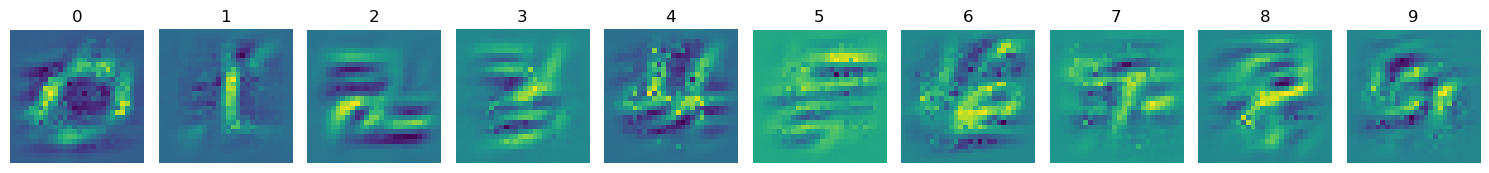

Iteration 16000 current batch loss: 0.0018861917778849602
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999452, 0.999628, 0.999772, 0.999736, 0.999752, 0.999737, 0.999599, 0.99973, 0.9997, 0.999533]


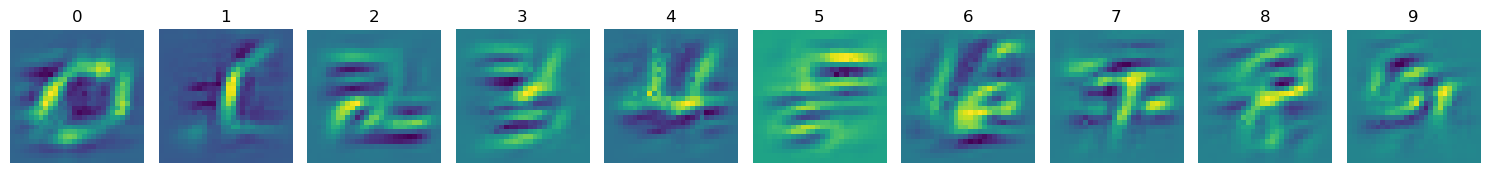

Iteration 18000 current batch loss: 0.0018377326196059585
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999462, 0.999634, 0.999772, 0.999742, 0.999763, 0.999739, 0.999603, 0.999731, 0.9997, 0.999562]


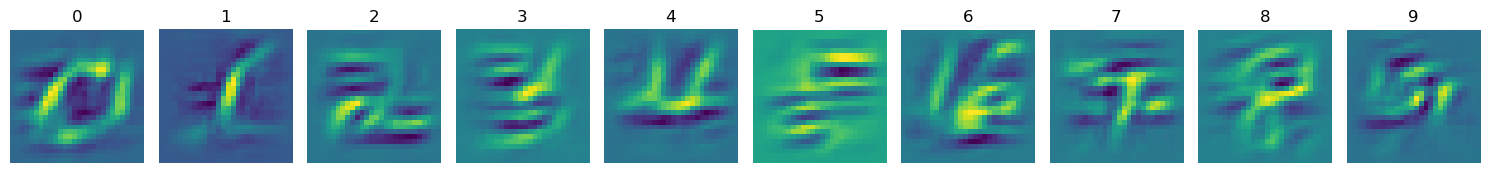

Iteration 20000 current batch loss: 0.001836512703448534
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999462, 0.999634, 0.999772, 0.999742, 0.999763, 0.999739, 0.999603, 0.999731, 0.9997, 0.999563]


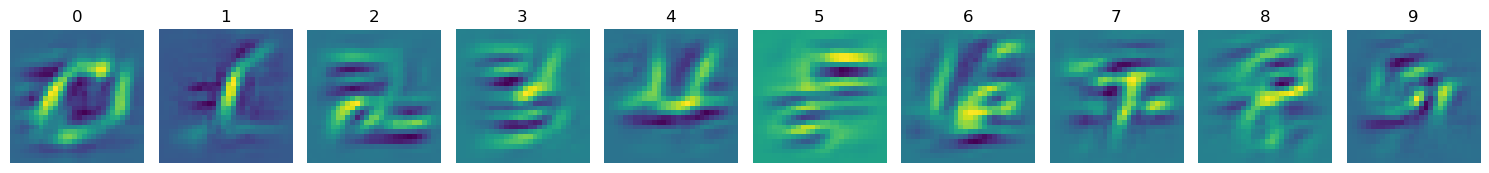

Iteration 22000 current batch loss: 0.0018365593859925866
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999462, 0.999634, 0.999772, 0.999742, 0.999763, 0.999739, 0.999603, 0.999731, 0.9997, 0.999563]


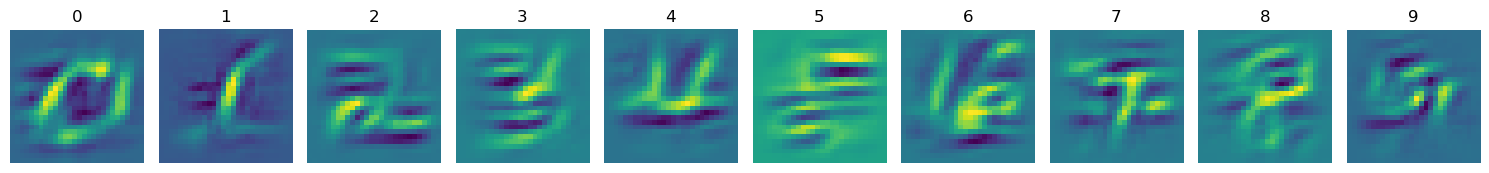

Iteration 24000 current batch loss: 0.0018365465803071856
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999462, 0.999634, 0.999772, 0.999742, 0.999763, 0.999739, 0.999603, 0.999731, 0.9997, 0.999563]


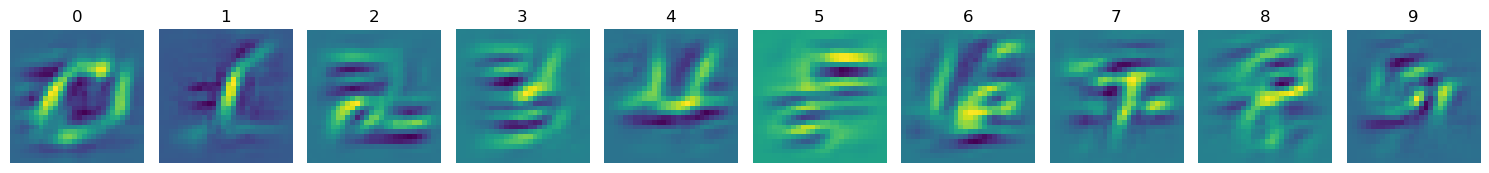

Iteration 26000 current batch loss: 0.0018365546129643917
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999462, 0.999634, 0.999772, 0.999742, 0.999763, 0.999739, 0.999603, 0.999732, 0.9997, 0.999563]


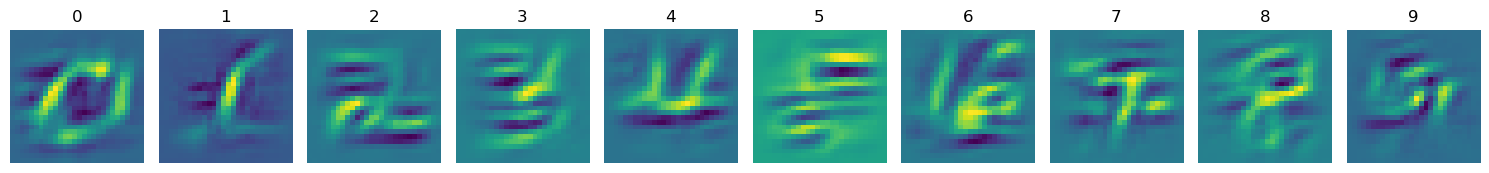

Iteration 28000 current batch loss: 0.0018365706782788038
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999461, 0.999634, 0.999772, 0.999742, 0.999763, 0.999739, 0.999603, 0.999731, 0.9997, 0.999563]


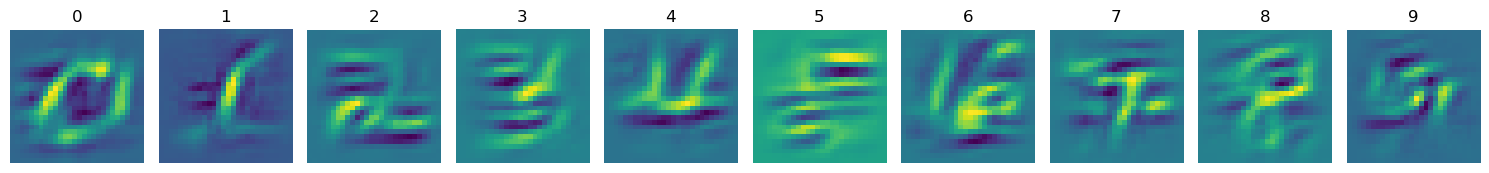

Iteration 30000 current batch loss: 0.001836536917835474
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999462, 0.999634, 0.999772, 0.999742, 0.999763, 0.999739, 0.999603, 0.999731, 0.9997, 0.999563]


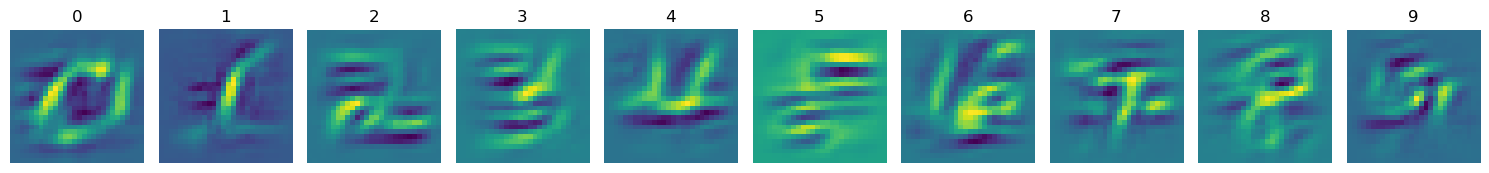

Iteration 32000 current batch loss: 0.0018365492578595877
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999462, 0.999634, 0.999772, 0.999742, 0.999763, 0.999739, 0.999603, 0.999731, 0.9997, 0.999563]


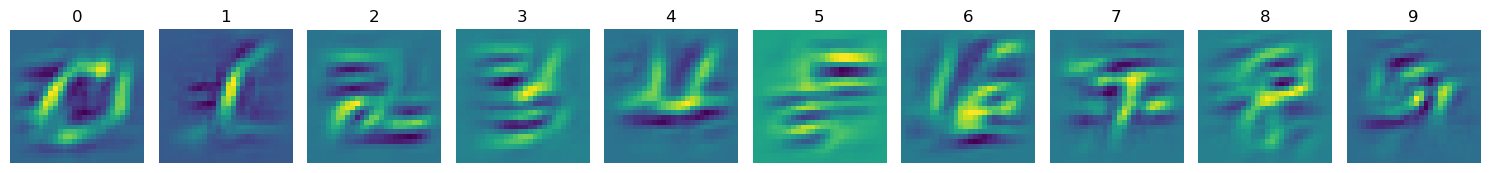

Iteration 34000 current batch loss: 0.0018365666037425399
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999462, 0.999634, 0.999772, 0.999742, 0.999763, 0.999739, 0.999603, 0.999732, 0.9997, 0.999563]


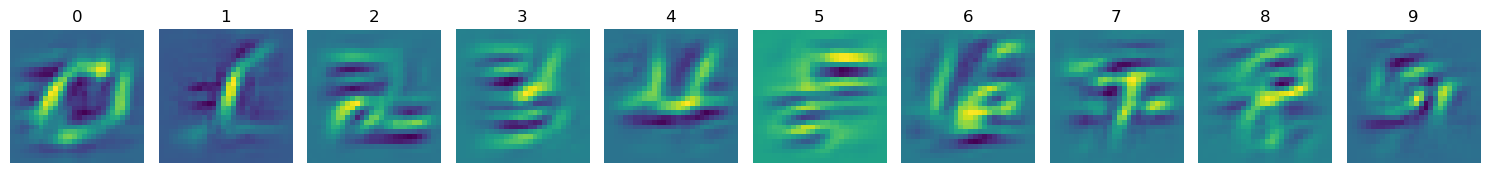

Iteration 36000 current batch loss: 0.0018366018775850534
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999462, 0.999634, 0.999772, 0.999742, 0.999763, 0.999739, 0.999603, 0.999731, 0.9997, 0.999563]


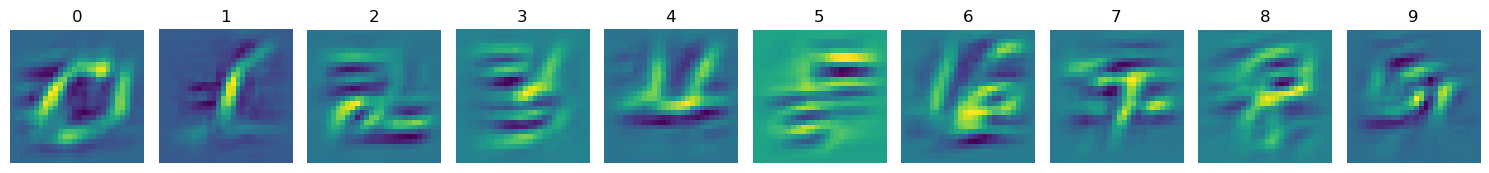

Iteration 38000 current batch loss: 0.0018365599680691957
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999461, 0.999634, 0.999772, 0.999742, 0.999763, 0.999739, 0.999603, 0.999731, 0.9997, 0.999563]


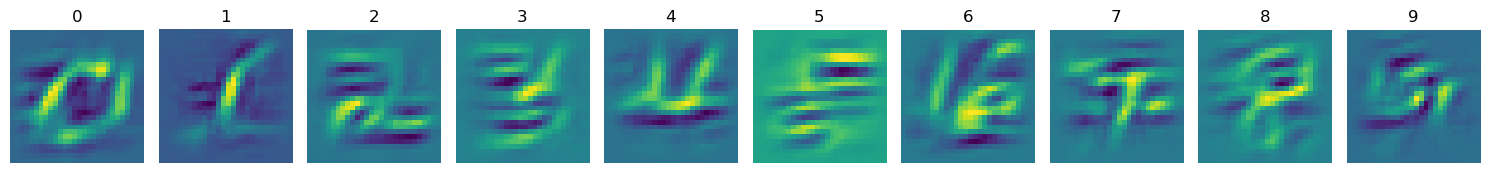

Iteration 40000 current batch loss: 0.00183655577711761
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999462, 0.999634, 0.999772, 0.999742, 0.999763, 0.999739, 0.999603, 0.999732, 0.9997, 0.999563]


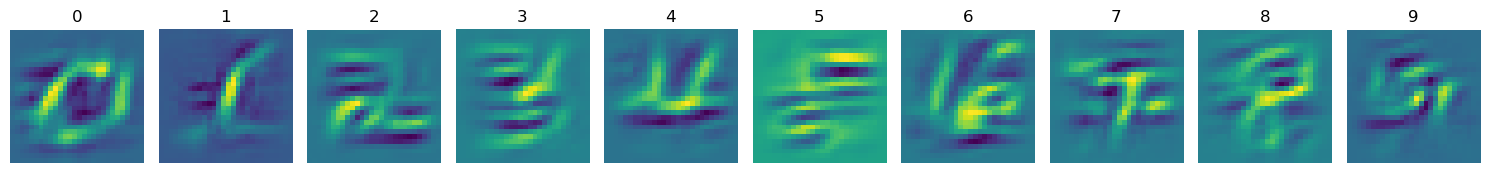

Iteration 40000 current batch loss: 0.00183655577711761


In [7]:
points_2 = train_input(net, lambda_l2 = 0.01, plot = True)

# $\lambda = 0.1$

Iteration 2000 current batch loss: 0.09521070122718811
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.97698, 0.960961, 0.995338, 0.992355, 0.990988, 0.992777, 0.978366, 0.990042, 0.993385, 0.979455]


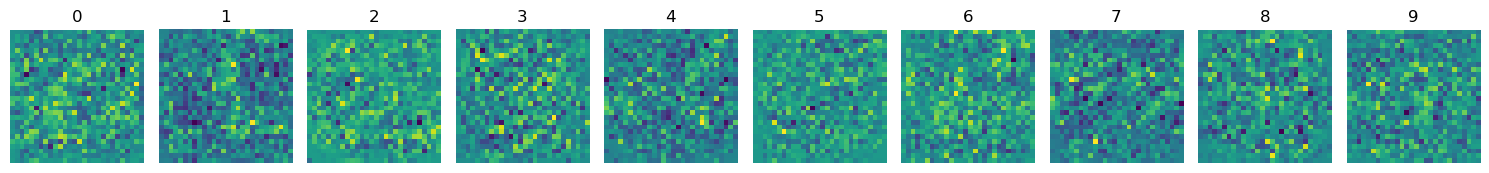

Iteration 4000 current batch loss: 0.058222778141498566
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.991909, 0.990932, 0.997359, 0.996441, 0.996616, 0.996518, 0.993248, 0.996383, 0.996461, 0.994666]


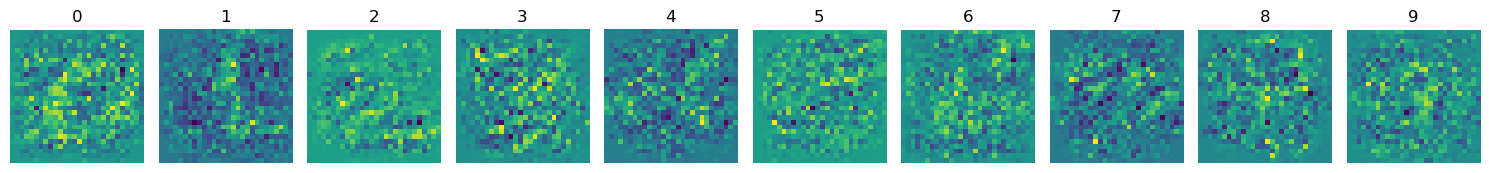

Iteration 6000 current batch loss: 0.033400893211364746
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.994671, 0.994866, 0.997766, 0.997221, 0.997477, 0.997582, 0.996002, 0.997585, 0.997155, 0.997203]


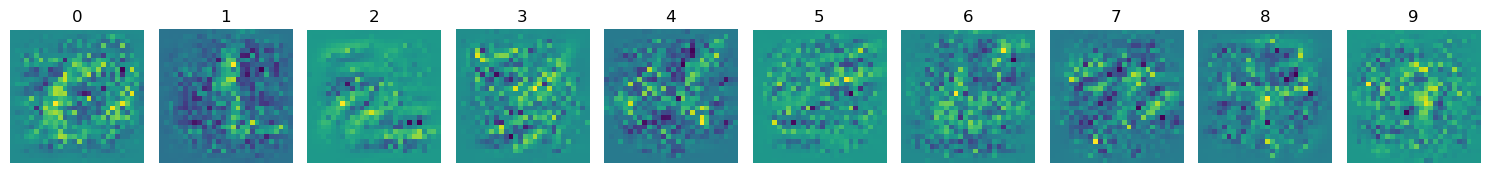

Iteration 8000 current batch loss: 0.018413454294204712
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99548, 0.995941, 0.997999, 0.997561, 0.997763, 0.997992, 0.996561, 0.99779, 0.997504, 0.997334]


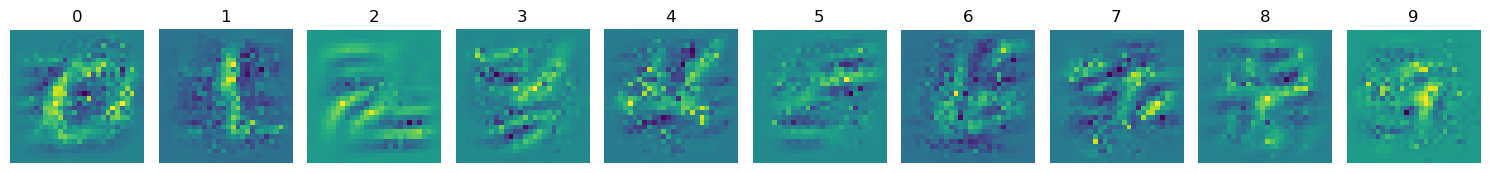

Iteration 10000 current batch loss: 0.012860764749348164
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99569, 0.996376, 0.998081, 0.997838, 0.998003, 0.998097, 0.99683, 0.997834, 0.997627, 0.997401]


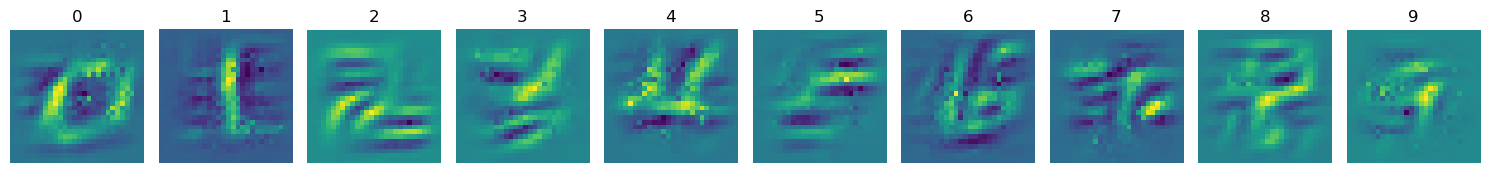

Iteration 12000 current batch loss: 0.0118973758071661
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.995817, 0.996463, 0.99809, 0.997875, 0.998123, 0.998108, 0.9969, 0.997914, 0.997664, 0.997439]


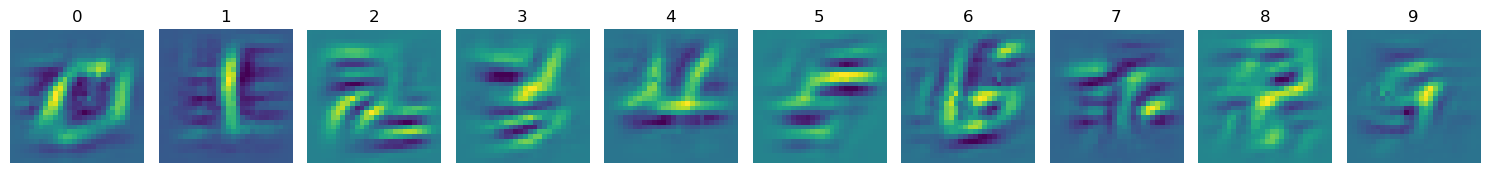

Iteration 14000 current batch loss: 0.011775171384215355
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.995861, 0.996495, 0.99809, 0.997884, 0.998135, 0.998108, 0.996994, 0.997918, 0.997668, 0.997442]


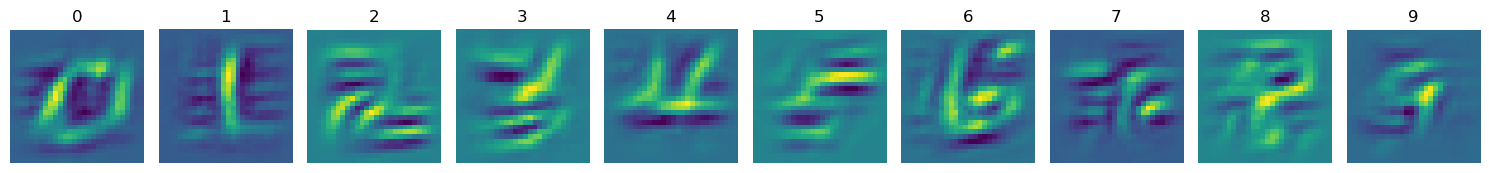

Iteration 16000 current batch loss: 0.011762747541069984
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.995862, 0.996497, 0.99809, 0.997883, 0.998134, 0.998107, 0.997022, 0.997919, 0.997668, 0.997441]


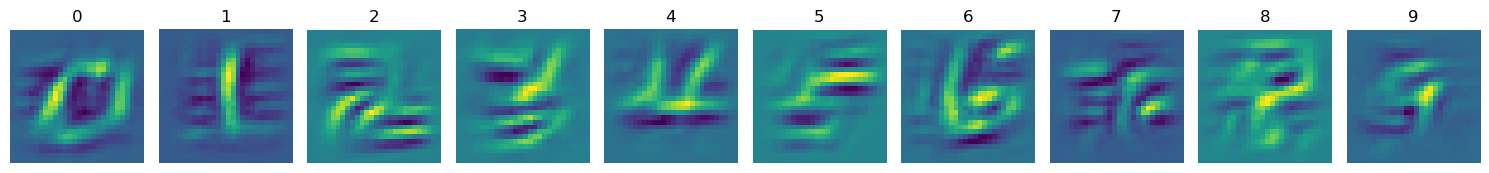

Iteration 18000 current batch loss: 0.011762860231101513
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.995861, 0.996498, 0.99809, 0.997883, 0.998133, 0.998108, 0.997022, 0.997917, 0.997667, 0.997441]


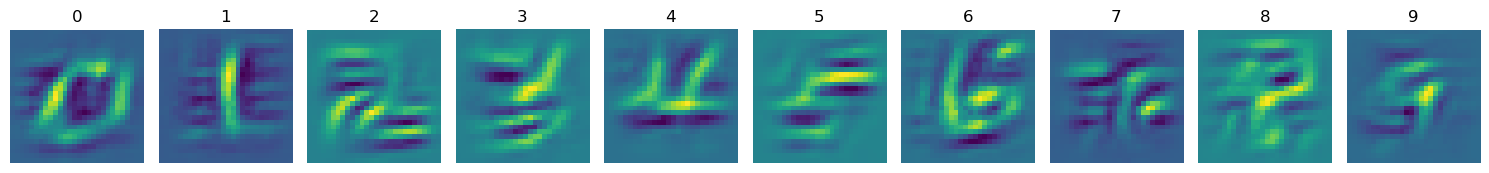

Iteration 20000 current batch loss: 0.011762682348489761
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.995862, 0.996499, 0.998089, 0.997883, 0.998135, 0.998107, 0.997022, 0.997919, 0.997667, 0.997442]


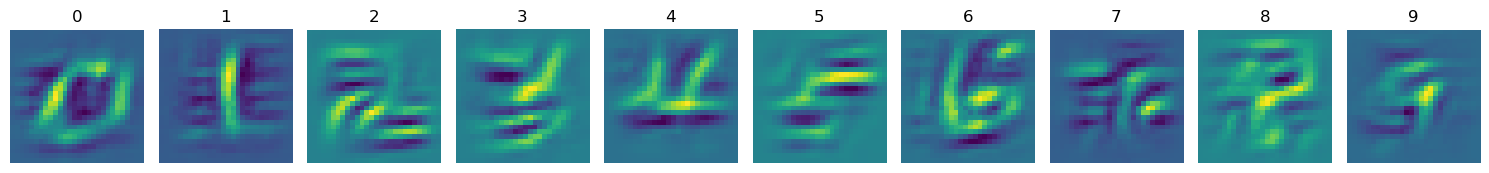

Iteration 22000 current batch loss: 0.011762700974941254
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.995861, 0.996499, 0.99809, 0.997882, 0.998135, 0.99811, 0.997023, 0.997918, 0.997668, 0.997441]


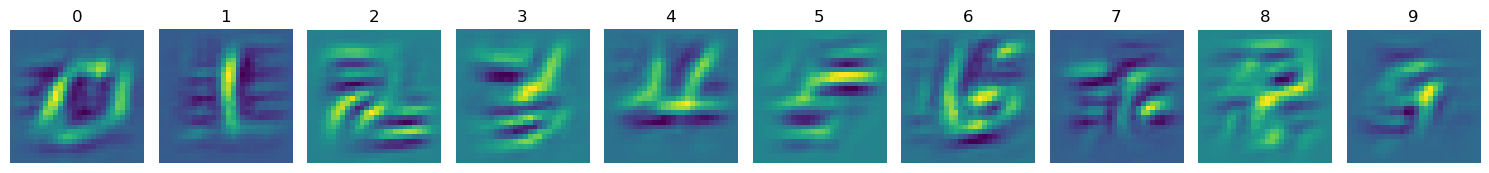

Iteration 24000 current batch loss: 0.01176278106868267
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.995862, 0.996496, 0.99809, 0.997884, 0.998135, 0.998109, 0.997021, 0.997918, 0.997667, 0.99744]


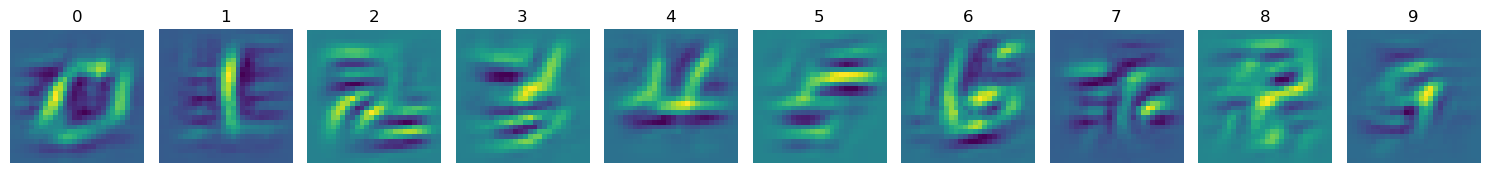

Iteration 26000 current batch loss: 0.011762717738747597
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99586, 0.996498, 0.998089, 0.997885, 0.998135, 0.998108, 0.997022, 0.99792, 0.997667, 0.997442]


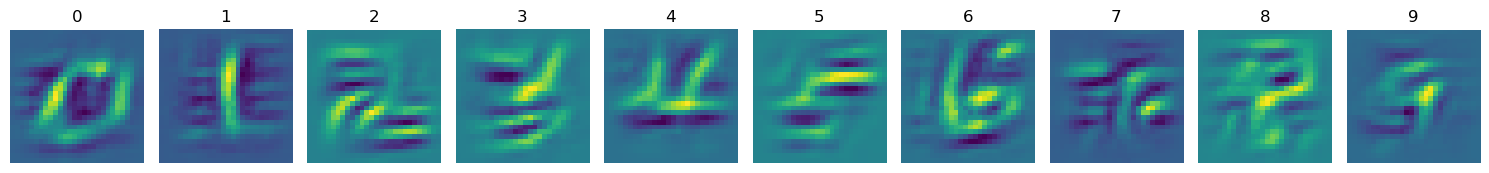

Iteration 28000 current batch loss: 0.011762724258005619
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.995861, 0.996499, 0.998092, 0.997883, 0.998135, 0.998109, 0.997022, 0.997918, 0.997667, 0.997442]


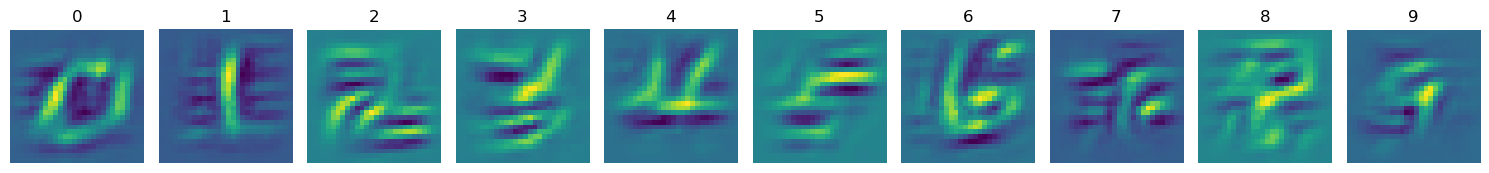

Iteration 30000 current batch loss: 0.011762753129005432
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.995862, 0.996499, 0.998088, 0.997882, 0.998134, 0.998108, 0.997021, 0.99792, 0.997668, 0.997442]


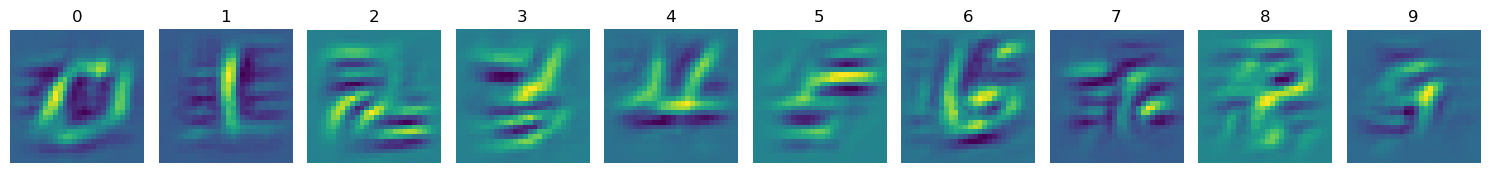

Iteration 32000 current batch loss: 0.011762607842683792
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.995862, 0.996498, 0.99809, 0.997883, 0.998134, 0.998108, 0.997021, 0.997919, 0.997668, 0.997442]


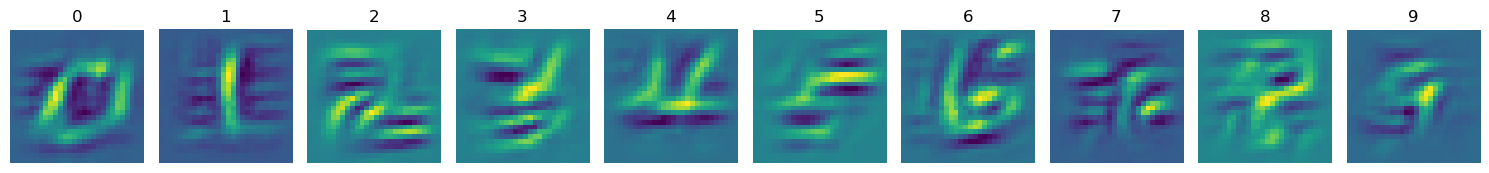

Iteration 34000 current batch loss: 0.011762736365199089
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.995862, 0.996498, 0.998091, 0.997884, 0.998135, 0.998108, 0.997021, 0.997919, 0.997667, 0.997441]


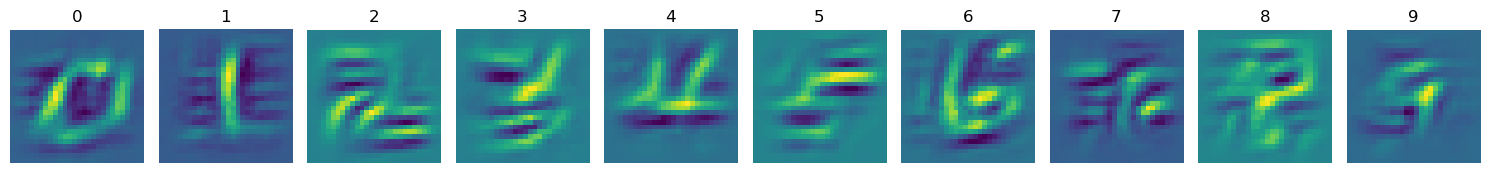

Iteration 36000 current batch loss: 0.011762719601392746
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.995862, 0.996496, 0.998089, 0.997884, 0.998135, 0.998109, 0.997021, 0.997919, 0.997667, 0.99744]


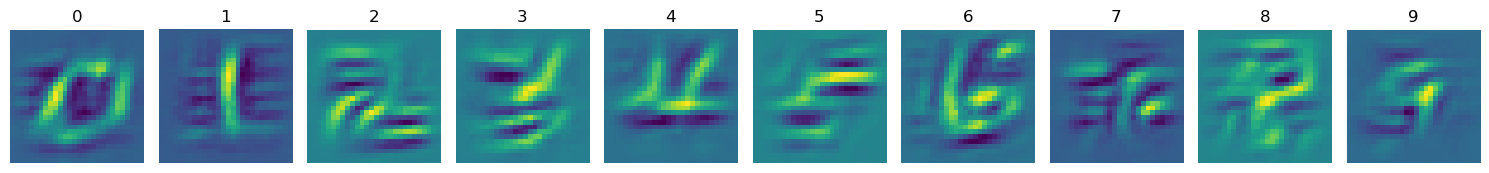

Iteration 38000 current batch loss: 0.011762814596295357
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.995862, 0.9965, 0.99809, 0.997882, 0.998135, 0.998108, 0.997024, 0.997919, 0.997667, 0.997442]


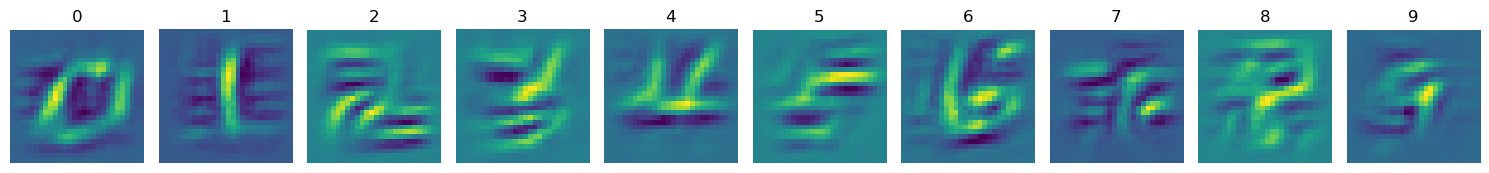

Iteration 40000 current batch loss: 0.011762652546167374
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.995861, 0.996497, 0.998089, 0.997883, 0.998135, 0.998108, 0.997022, 0.997918, 0.997667, 0.997441]


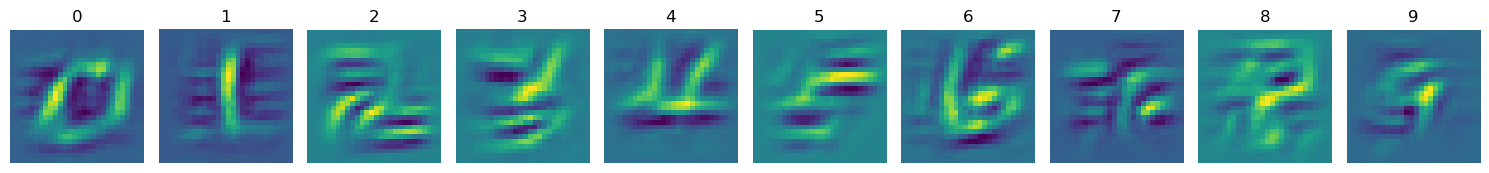

Iteration 40000 current batch loss: 0.011762652546167374


In [8]:
points_3 = train_input(net, lambda_l2 = 0.1, plot = True)

# $\lambda = 1$

Iteration 2000 current batch loss: 0.3673825263977051
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.943983, 0.937552, 0.982359, 0.977169, 0.978744, 0.980838, 0.963243, 0.976882, 0.979641, 0.966957]


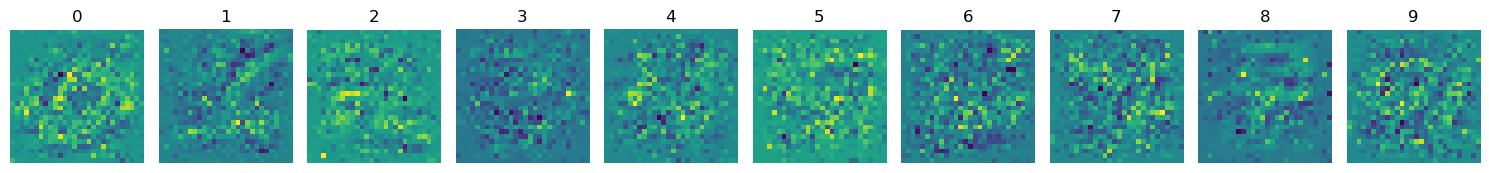

Iteration 4000 current batch loss: 0.12909407913684845
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.961486, 0.96225, 0.984928, 0.983127, 0.985324, 0.985468, 0.975125, 0.982761, 0.983065, 0.974954]


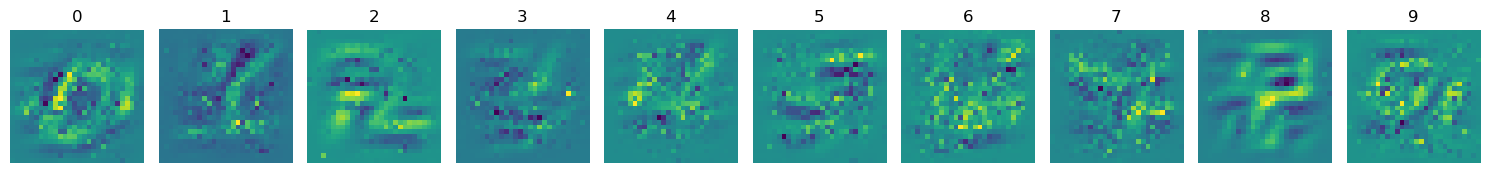

Iteration 6000 current batch loss: 0.07705656439065933
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.967546, 0.964851, 0.986217, 0.983843, 0.986037, 0.987082, 0.977778, 0.984484, 0.983377, 0.977804]


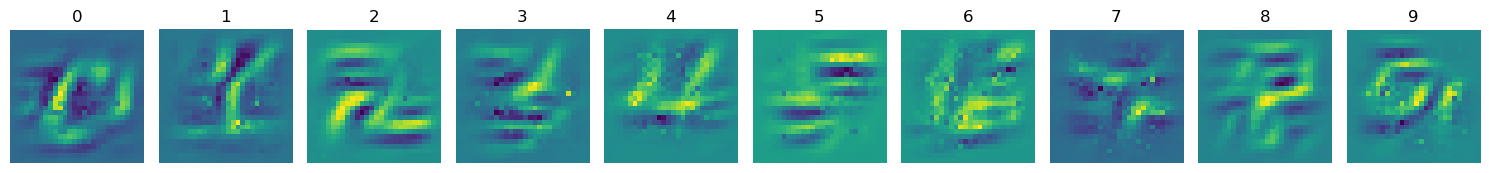

Iteration 8000 current batch loss: 0.07053408026695251
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.970854, 0.965211, 0.986741, 0.983779, 0.986765, 0.987107, 0.980183, 0.985222, 0.983379, 0.978292]


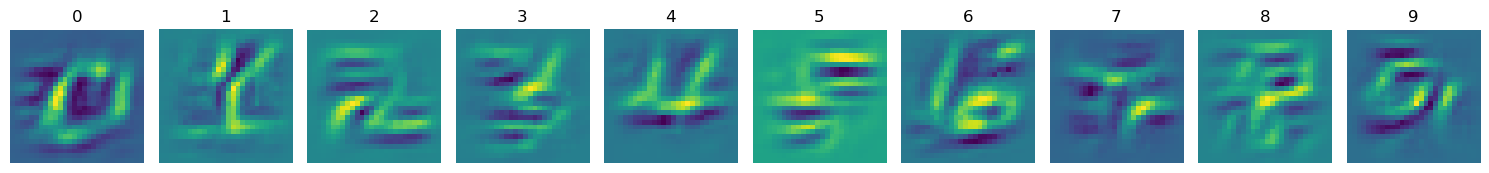

Iteration 10000 current batch loss: 0.07006441056728363
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.971201, 0.96524, 0.986737, 0.983804, 0.9868, 0.987105, 0.980459, 0.985273, 0.983373, 0.978436]


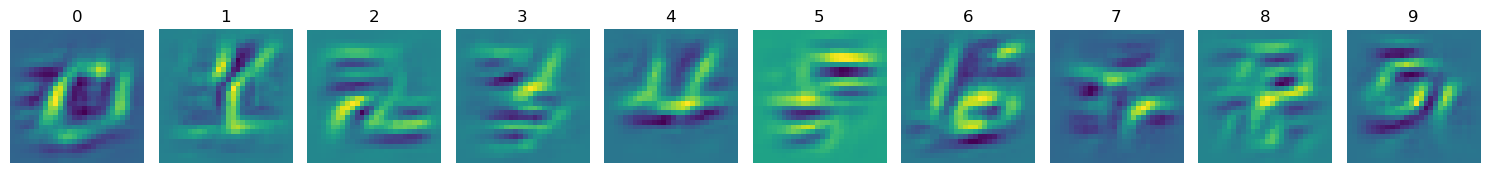

Iteration 12000 current batch loss: 0.07005675882101059
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.971199, 0.965242, 0.986739, 0.983839, 0.986801, 0.987106, 0.980461, 0.985272, 0.98338, 0.978423]


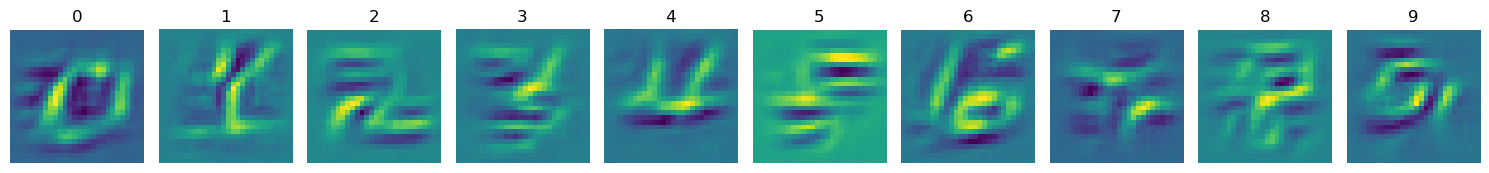

Iteration 14000 current batch loss: 0.07005750387907028
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.971197, 0.965236, 0.986739, 0.98383, 0.986803, 0.987094, 0.980463, 0.985274, 0.983383, 0.978432]


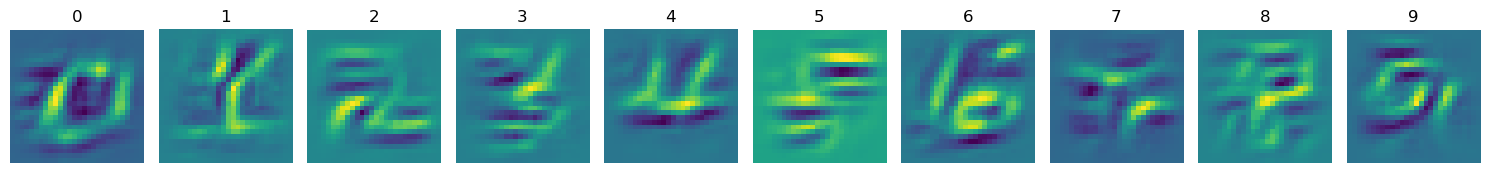

Iteration 16000 current batch loss: 0.07005764544010162
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.971208, 0.965241, 0.986735, 0.983845, 0.9868, 0.987104, 0.980456, 0.985271, 0.983371, 0.978406]


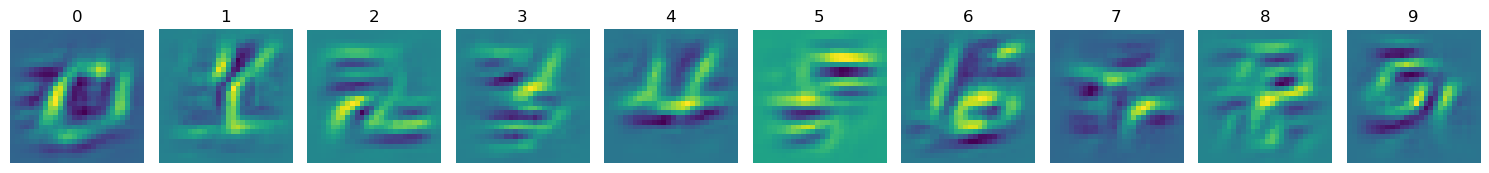

Iteration 18000 current batch loss: 0.07005804777145386
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.971204, 0.965248, 0.986737, 0.983843, 0.986803, 0.987113, 0.980465, 0.985284, 0.98337, 0.97843]


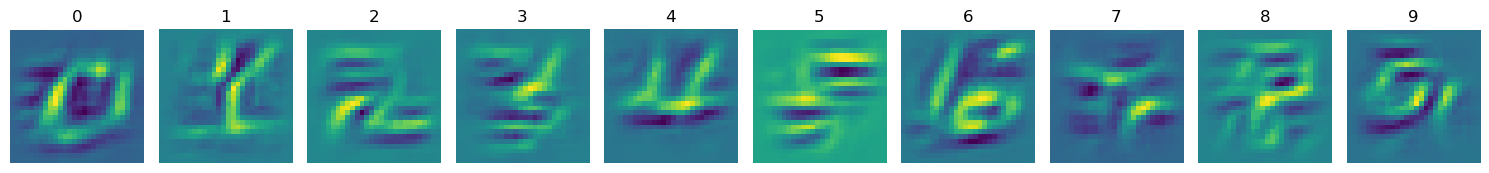

Iteration 20000 current batch loss: 0.07005833089351654
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.9712, 0.965258, 0.986735, 0.983846, 0.986809, 0.987091, 0.980465, 0.985271, 0.983374, 0.978441]


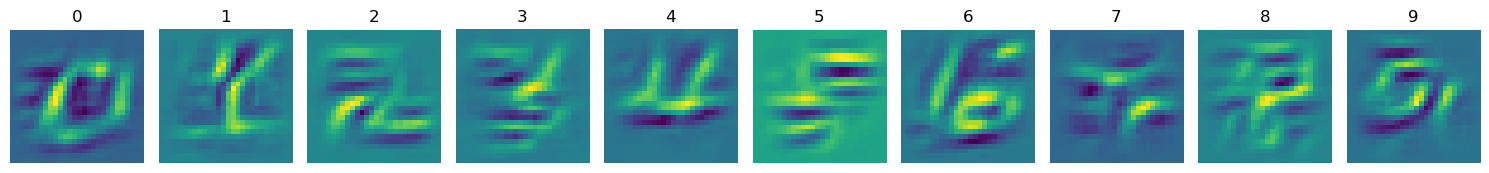

Iteration 22000 current batch loss: 0.07005789875984192
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.971201, 0.965253, 0.986735, 0.98384, 0.986799, 0.987099, 0.980458, 0.985266, 0.983377, 0.97842]


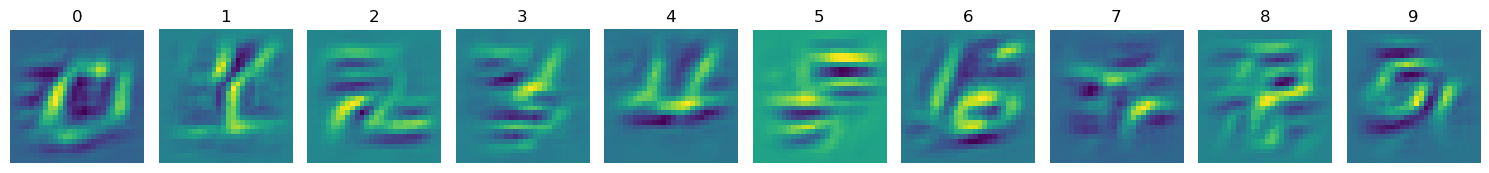

Iteration 24000 current batch loss: 0.07005783915519714
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.9712, 0.965239, 0.986738, 0.983842, 0.986803, 0.987099, 0.980464, 0.98529, 0.983378, 0.978429]


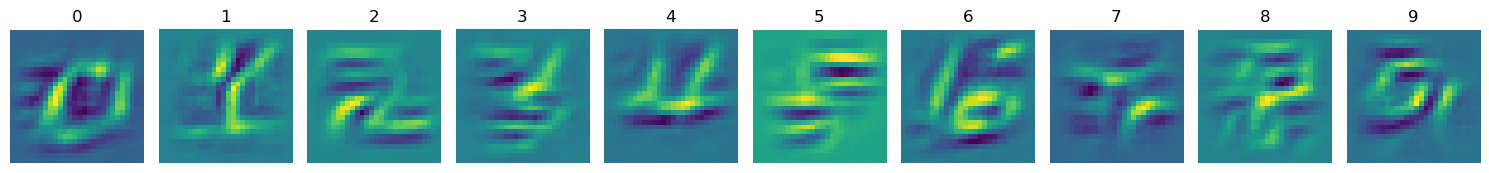

Iteration 26000 current batch loss: 0.07005807012319565
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.971205, 0.965248, 0.986738, 0.98384, 0.986793, 0.987105, 0.980454, 0.985269, 0.983368, 0.978433]


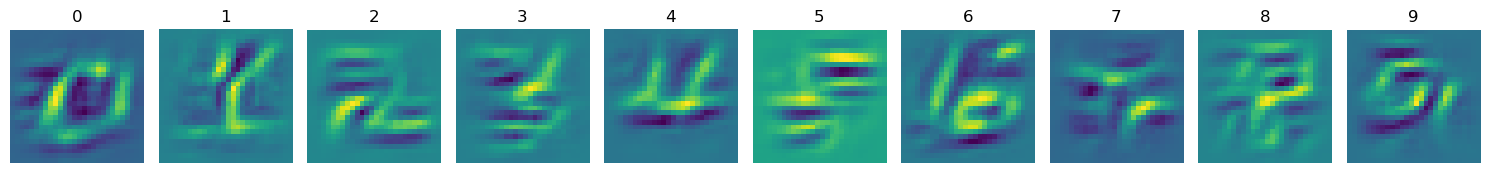

Iteration 28000 current batch loss: 0.07005833089351654
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.971205, 0.965247, 0.986733, 0.983842, 0.986804, 0.987117, 0.980455, 0.985274, 0.983375, 0.978433]


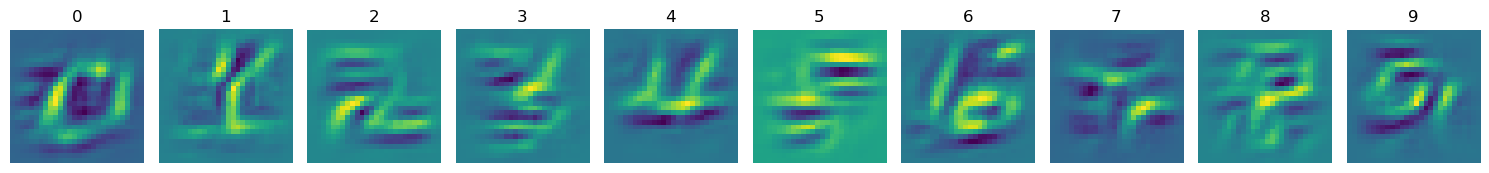

Iteration 30000 current batch loss: 0.07005801796913147
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.971201, 0.965241, 0.986737, 0.98384, 0.986794, 0.987111, 0.980474, 0.985283, 0.983379, 0.978433]


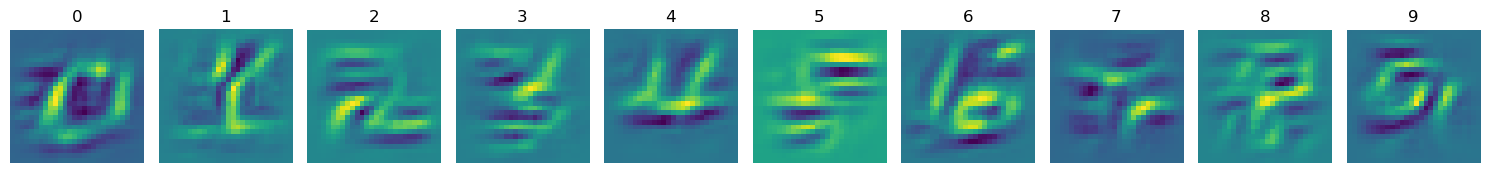

Iteration 32000 current batch loss: 0.07005826383829117
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.971197, 0.965245, 0.986734, 0.983844, 0.986791, 0.987099, 0.98047, 0.985272, 0.983365, 0.978422]


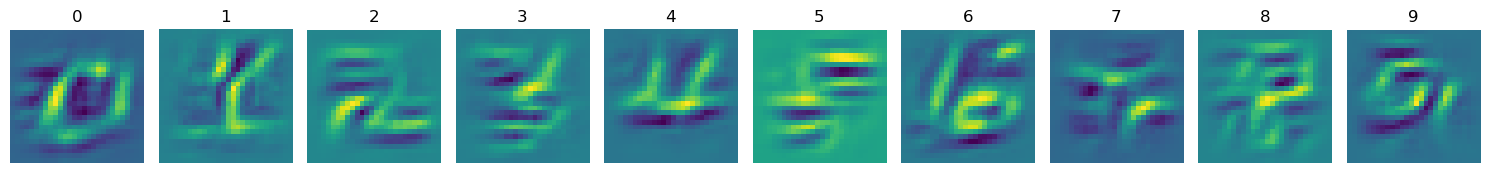

Iteration 34000 current batch loss: 0.07005765289068222
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.971197, 0.96525, 0.986739, 0.983849, 0.986801, 0.987098, 0.980462, 0.985267, 0.983381, 0.978425]


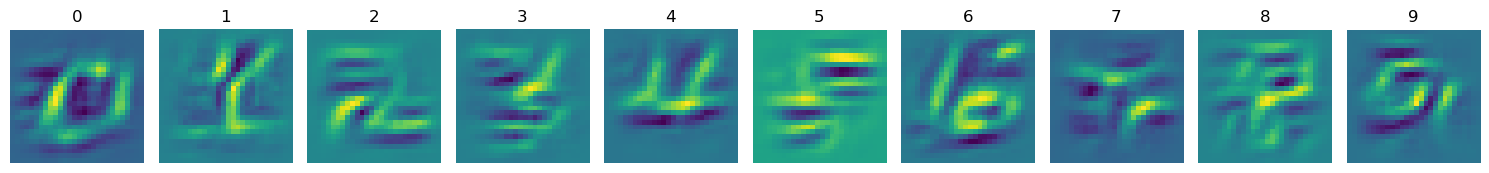

Iteration 36000 current batch loss: 0.0700572282075882
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.971202, 0.965236, 0.986738, 0.983843, 0.986798, 0.987109, 0.980475, 0.985278, 0.983371, 0.978431]


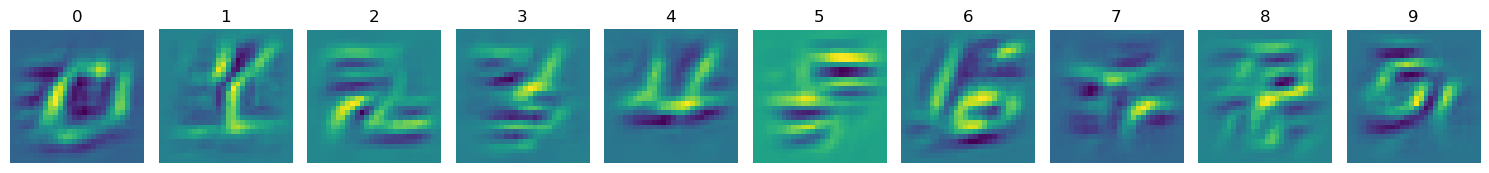

Iteration 38000 current batch loss: 0.070057213306427
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.971199, 0.965241, 0.986738, 0.983839, 0.9868, 0.987109, 0.980469, 0.985277, 0.983375, 0.978423]


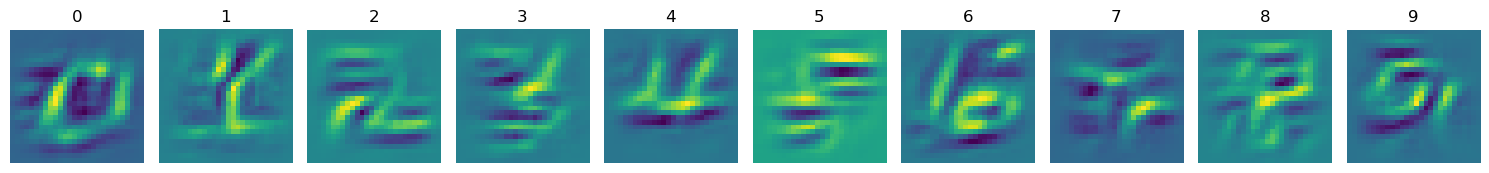

Iteration 40000 current batch loss: 0.07005831599235535
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.971203, 0.965247, 0.986737, 0.98384, 0.986808, 0.987107, 0.980466, 0.985279, 0.983374, 0.97842]


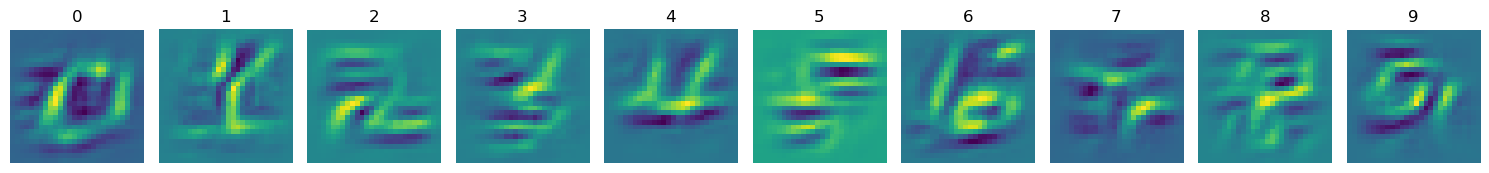

Iteration 40000 current batch loss: 0.07005831599235535


In [9]:
points_4 = train_input(net, lambda_l2 = 1, plot = True)

# $\lambda = 10$

Iteration 2000 current batch loss: 0.9467023611068726
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.803084, 0.808153, 0.899035, 0.894547, 0.899653, 0.904202, 0.853627, 0.894182, 0.880299, 0.835193]


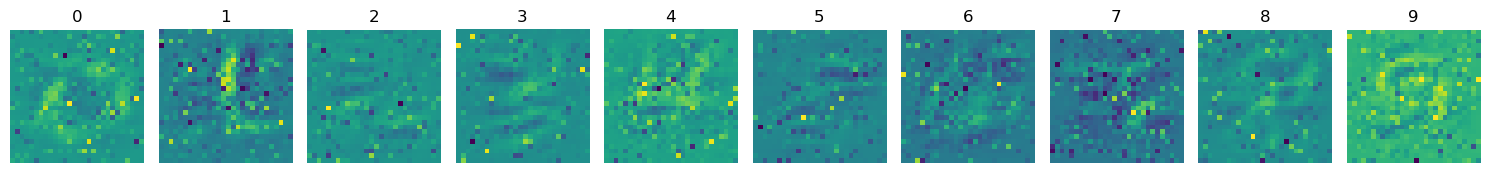

Iteration 4000 current batch loss: 0.346264123916626
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.827947, 0.844489, 0.917238, 0.900802, 0.908543, 0.916213, 0.876426, 0.907887, 0.887454, 0.859323]


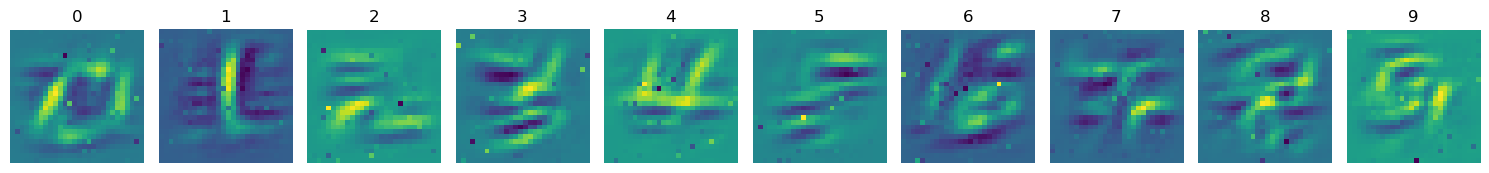

Iteration 6000 current batch loss: 0.32550546526908875
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.830118, 0.847632, 0.92094, 0.901485, 0.911904, 0.918967, 0.880651, 0.908566, 0.888452, 0.86478]


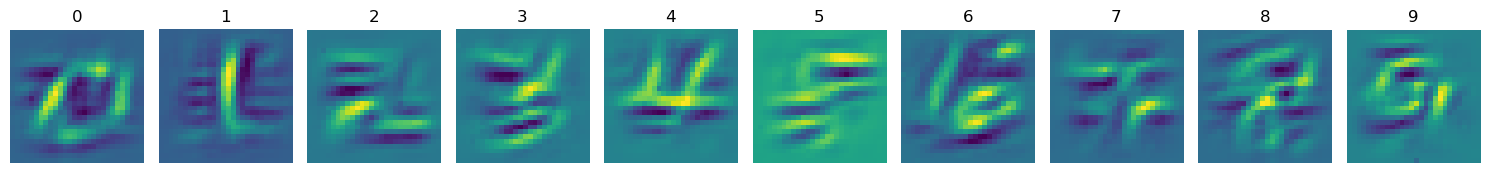

Iteration 8000 current batch loss: 0.32509565353393555
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.830333, 0.847785, 0.921143, 0.901603, 0.912404, 0.918992, 0.880803, 0.908596, 0.888676, 0.864734]


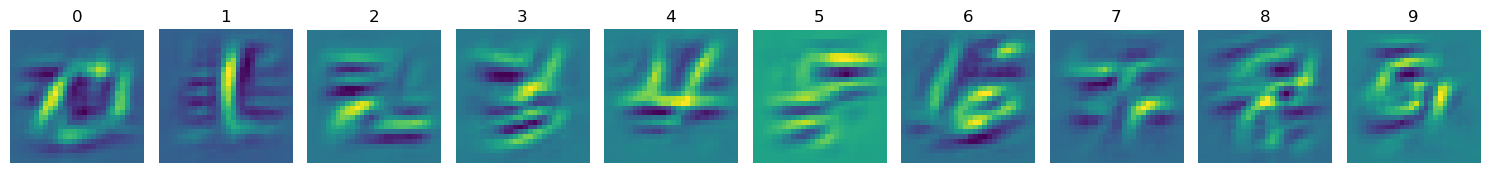

Iteration 10000 current batch loss: 0.32510411739349365
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.830334, 0.847779, 0.921159, 0.901619, 0.912402, 0.918995, 0.880896, 0.9086, 0.88874, 0.864769]


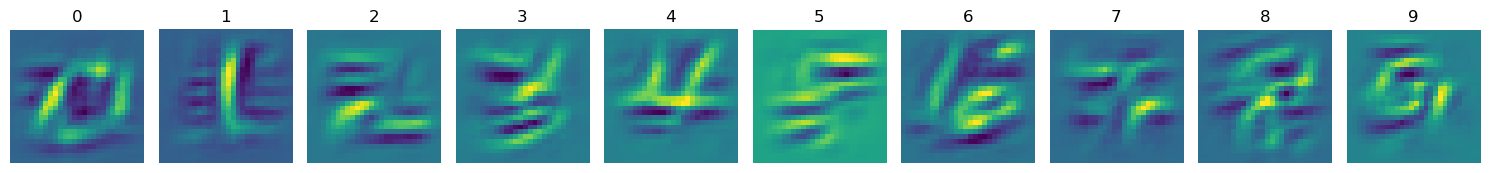

Iteration 12000 current batch loss: 0.3250960409641266
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.830348, 0.847761, 0.921143, 0.901603, 0.91245, 0.919026, 0.880835, 0.908601, 0.888786, 0.864712]


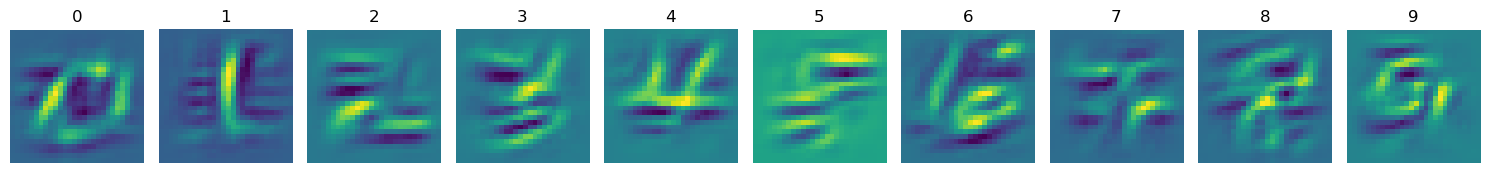

Iteration 14000 current batch loss: 0.32509827613830566
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.830297, 0.847743, 0.921137, 0.901603, 0.912466, 0.919018, 0.881096, 0.908665, 0.888739, 0.864712]


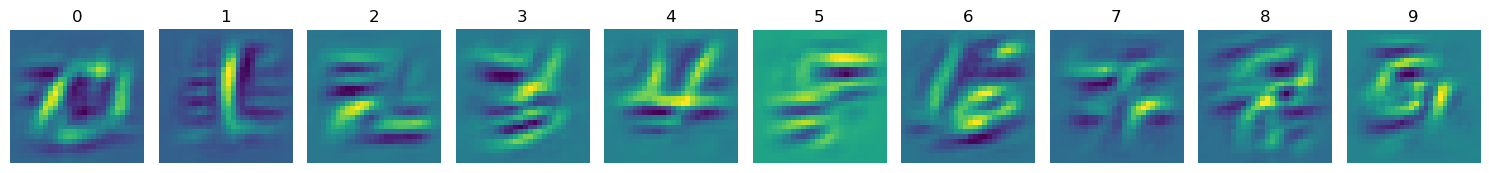

Iteration 16000 current batch loss: 0.325100302696228
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.830342, 0.847806, 0.921145, 0.901571, 0.912471, 0.919001, 0.880867, 0.908537, 0.888656, 0.864712]


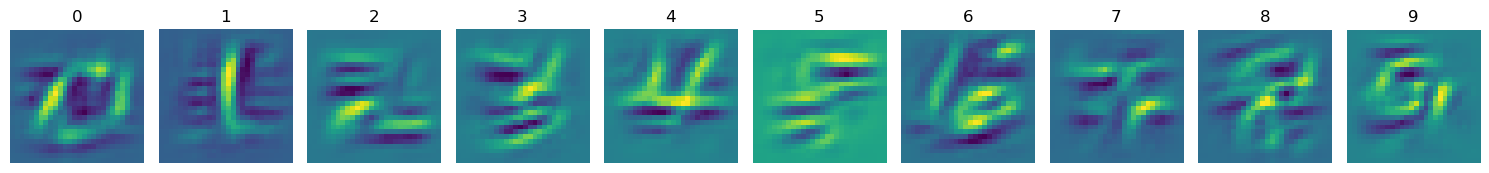

Iteration 18000 current batch loss: 0.32510045170783997
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.830384, 0.847802, 0.921119, 0.90155, 0.912427, 0.918995, 0.880793, 0.908531, 0.888705, 0.864796]


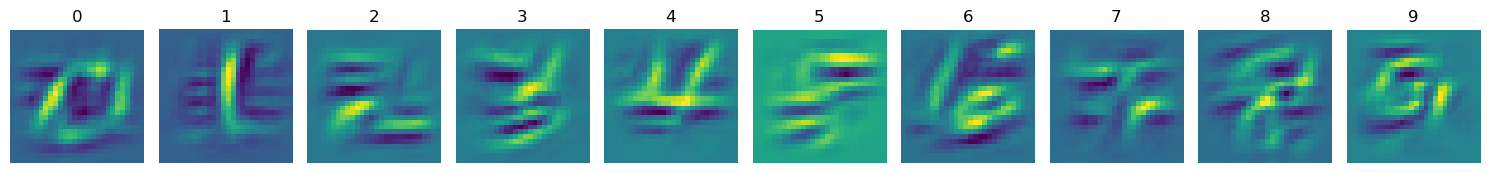

Iteration 20000 current batch loss: 0.3250989317893982
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.83032, 0.84777, 0.921136, 0.901659, 0.912427, 0.919022, 0.880981, 0.908595, 0.888741, 0.864805]


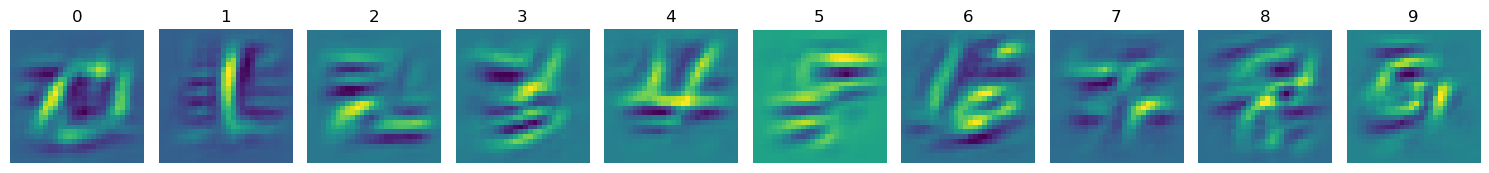

Iteration 22000 current batch loss: 0.32509520649909973
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.830323, 0.847762, 0.921168, 0.901608, 0.912437, 0.919046, 0.880804, 0.908577, 0.888687, 0.864693]


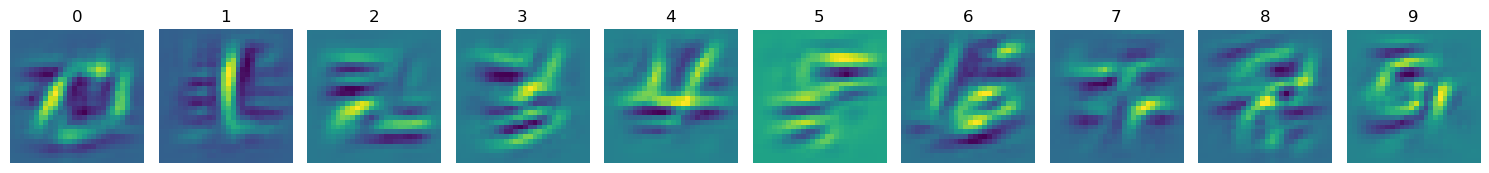

Iteration 24000 current batch loss: 0.3250970244407654
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.830329, 0.847751, 0.921149, 0.901617, 0.912441, 0.918993, 0.88091, 0.908641, 0.888723, 0.864723]


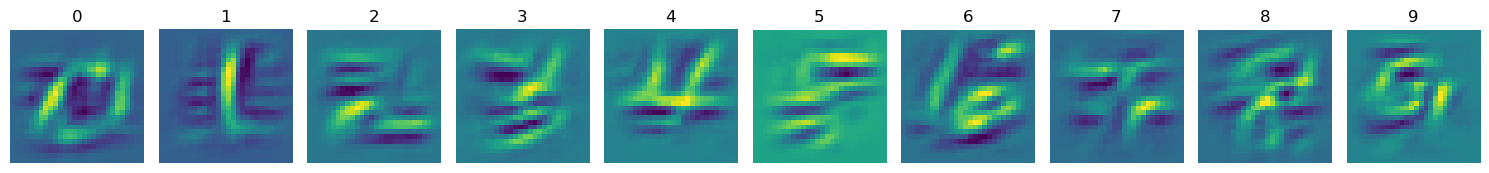

Iteration 26000 current batch loss: 0.3250969648361206
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.830371, 0.847736, 0.921127, 0.901637, 0.912449, 0.91903, 0.881001, 0.908612, 0.888768, 0.864719]


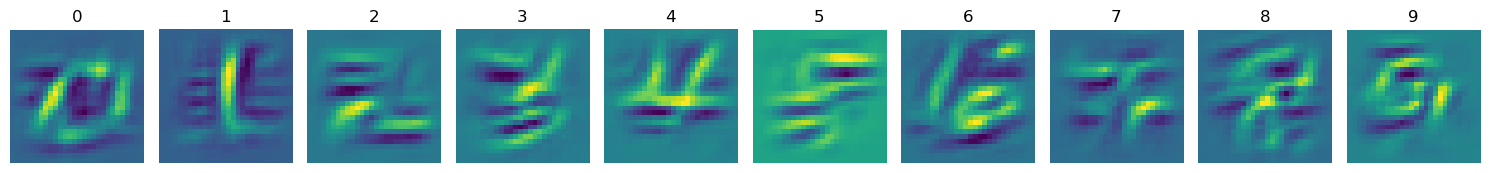

Iteration 28000 current batch loss: 0.32509398460388184
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.830328, 0.847786, 0.921159, 0.901637, 0.912407, 0.919001, 0.880917, 0.908569, 0.888712, 0.864733]


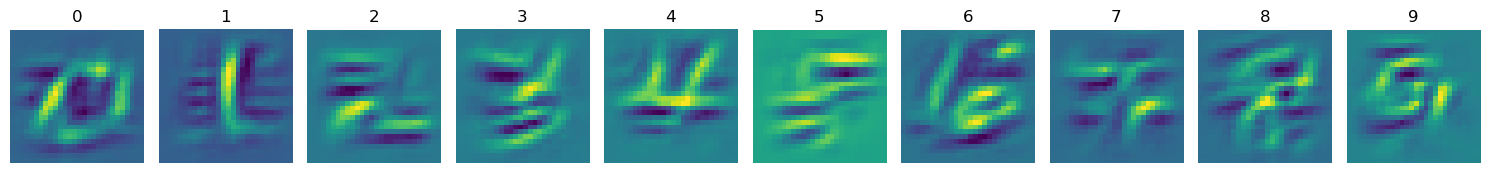

Iteration 30000 current batch loss: 0.32509535551071167
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.830321, 0.847786, 0.921153, 0.901593, 0.912494, 0.919015, 0.880859, 0.908621, 0.88868, 0.864729]


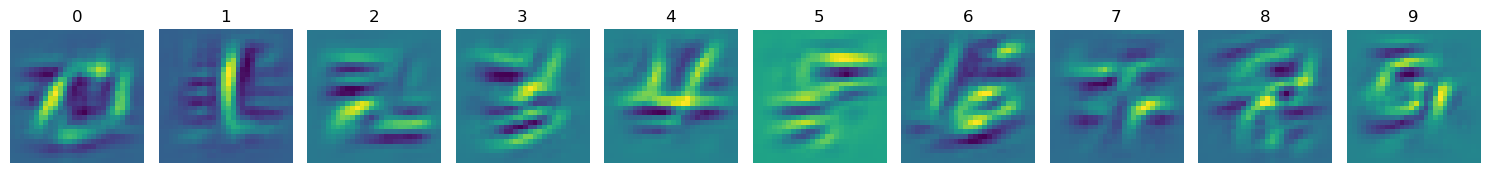

Iteration 32000 current batch loss: 0.3250981569290161
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.830332, 0.847736, 0.921173, 0.901611, 0.912401, 0.919001, 0.880841, 0.908587, 0.888721, 0.864772]


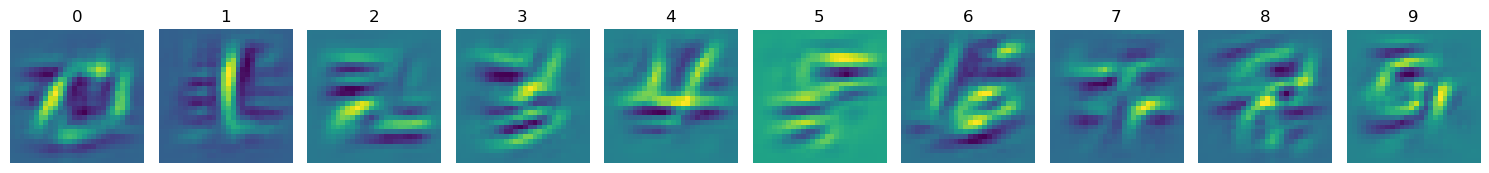

Iteration 34000 current batch loss: 0.32509681582450867
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.830332, 0.847764, 0.921178, 0.901669, 0.912434, 0.919009, 0.880881, 0.908654, 0.88875, 0.864712]


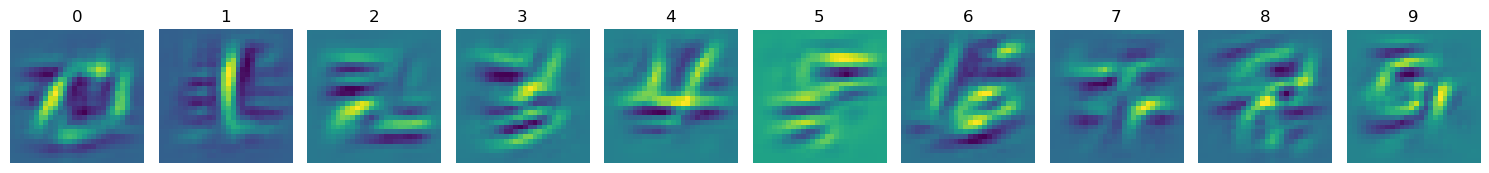

Iteration 36000 current batch loss: 0.3250974714756012
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.830382, 0.847789, 0.921142, 0.901678, 0.912472, 0.919009, 0.880862, 0.908532, 0.888703, 0.864703]


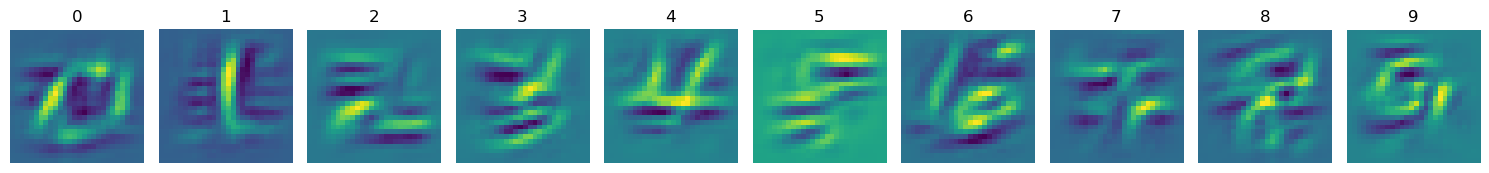

Iteration 38000 current batch loss: 0.3250943720340729
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.830339, 0.84776, 0.921132, 0.901648, 0.912458, 0.919028, 0.880848, 0.908545, 0.888673, 0.864745]


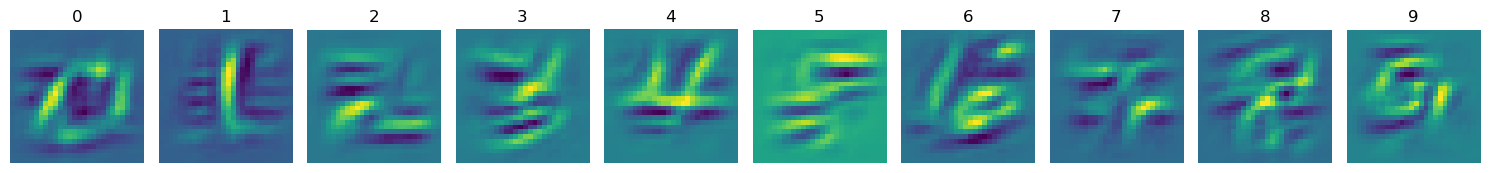

Iteration 40000 current batch loss: 0.32509511709213257
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.830348, 0.847686, 0.921159, 0.901651, 0.912463, 0.918993, 0.880969, 0.908595, 0.888739, 0.864675]


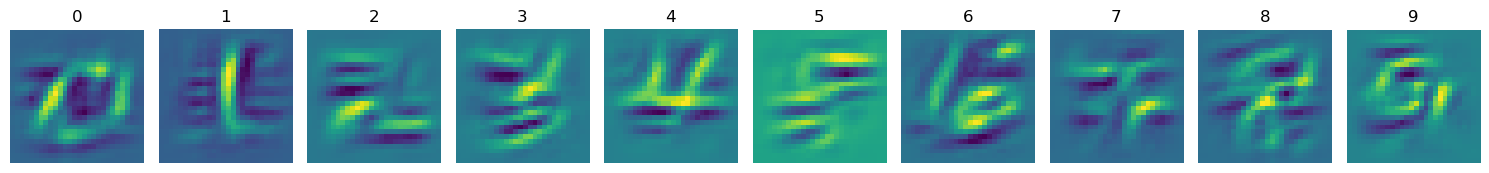

Iteration 40000 current batch loss: 0.32509511709213257


In [10]:
points_5 = train_input(net, lambda_l2 = 10, plot = True)

lambda = 0


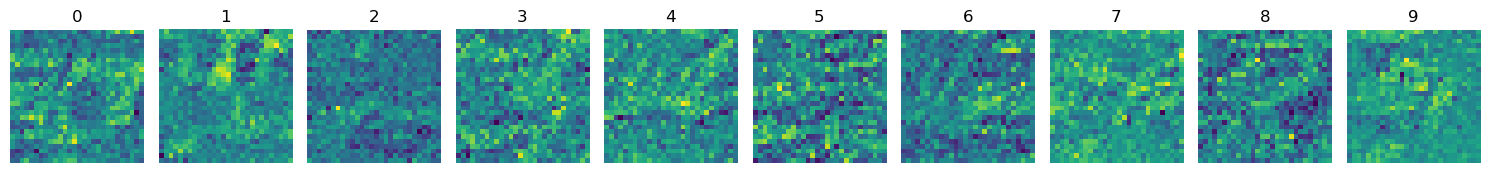

lambda = 0.01


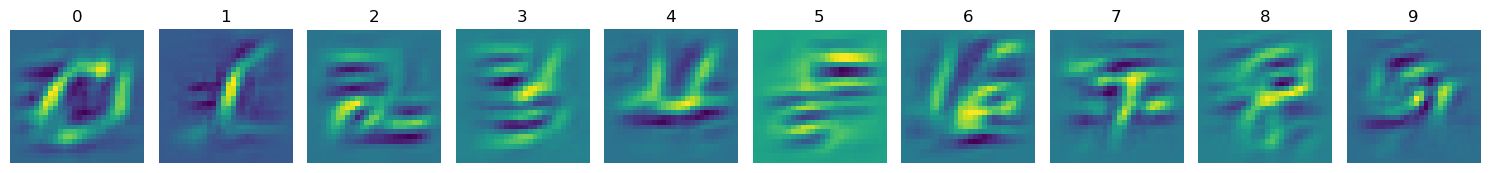

lambda = 0.1


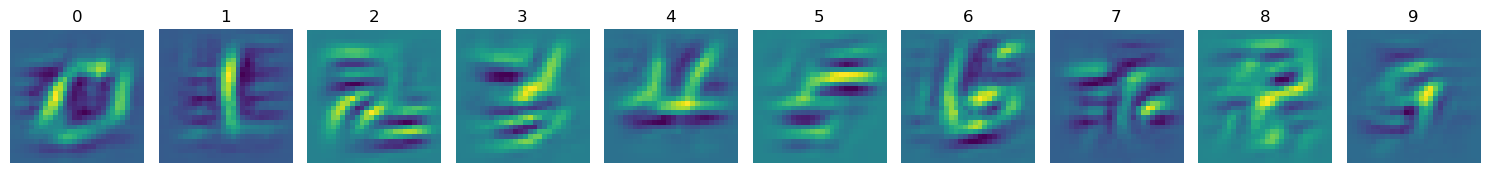

lambda = 1


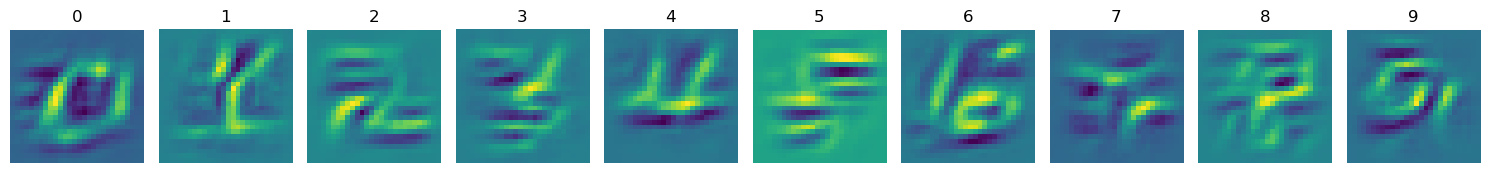

lambda = 10


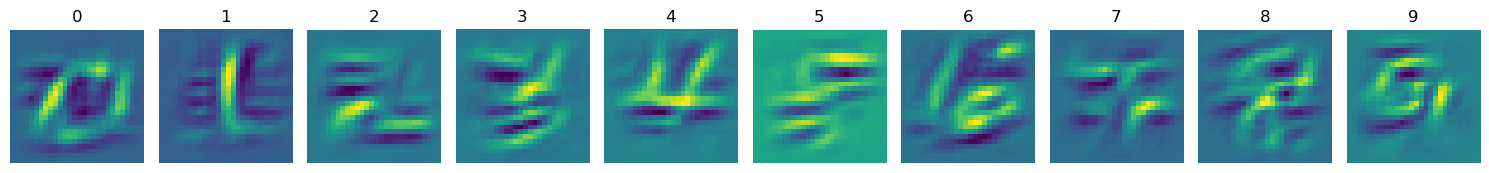

In [11]:
print("lambda = 0")
plot_numbers(points_1)
print("lambda = 0.01")
plot_numbers(points_2)
print("lambda = 0.1")
plot_numbers(points_3)
print("lambda = 1")
plot_numbers(points_4)
print("lambda = 10")
plot_numbers(points_5) # final plots

# Conclusions for task 1
-
-
- 

# Task 2

Firstly, we are going to create batch. We are going to take 9 examples of every number and define fake labels. 

In [12]:
k = 9
targets = trainset.targets                  
idx_all = torch.cat([
    (targets == c).nonzero(as_tuple=True)[0][:k]  
    for c in range(10)
])

batch_imgs   = torch.stack([trainset[i][0] for i in idx_all])   
batch_labels = targets[idx_all]

for k in range(0,10):
    batch_labels[(9*k):9*(k + 1)] = torch.tensor([x for x in range(0, 10) if x != k])


batch_imgs = batch_imgs.to(device)
batch_labels = batch_labels.to(device)      

In [13]:
def plot_one_number(points):   # function for plotting

    img = points.squeeze().detach().cpu().numpy()
    pyplot.imshow(img)                 
    pyplot.tight_layout()
    pyplot.show()

Let's define our main function. It is similar to function from previous homework but now we are going to train noise and not whole image. 

In [14]:
def train_noise(net, img, label, lr = 0.5, max_iter = 2000, info = 200, lambda_l2 = 10, plot = False):
    net.eval()
    for parameters in net.parameters():
        parameters.requires_grad = False   # freezing model
        
    noise = torch.zeros(1, 28, 28).to(device)
    noise.requires_grad = True
    true = label    
    
    optimizer = torch.optim.Adam([noise], lr)
    
    epoch = 0
        
    while epoch < max_iter:
        
        optimizer.zero_grad()
        preds = net(img + noise)   
        loss = torch.nn.functional.cross_entropy(preds, true, reduction = "mean") + lambda_l2 * noise.pow(2).mean()
    
        
        epoch += 1
        if info > 0 and epoch % info == 0:
            with torch.no_grad():
                print("Iteration", epoch, "current batch loss:", loss.item())
                print(torch.argmax(net(img + noise)))
                if plot:
                    plot_one_number(img + noise)
            
        loss.backward()     
        optimizer.step()     
    
    print("Iteration", epoch, "final batch loss:", loss.item())
    print("Final prediction", torch.argmax(net(img + noise)))
        
    for parameters in net.parameters():
            parameters.requires_grad = True  # unfreezing model
    return noise + img

In [15]:
def plot_images_grid(imgs, rows=10, cols=9, figsize=(15, 17)):
  

    fig, axes = pyplot.subplots(rows, cols, figsize=figsize)
    axes_flat = axes.flat if rows > 1 else [axes]

    for ax, img in zip(axes_flat, imgs):
        ax.set_title(f"Predicted: {torch.argmax(net(img))} ", fontsize=10)
        img = img.squeeze().detach().cpu().numpy()
        ax.imshow(img)
        ax.axis('off')

    pyplot.tight_layout()
    pyplot.show()

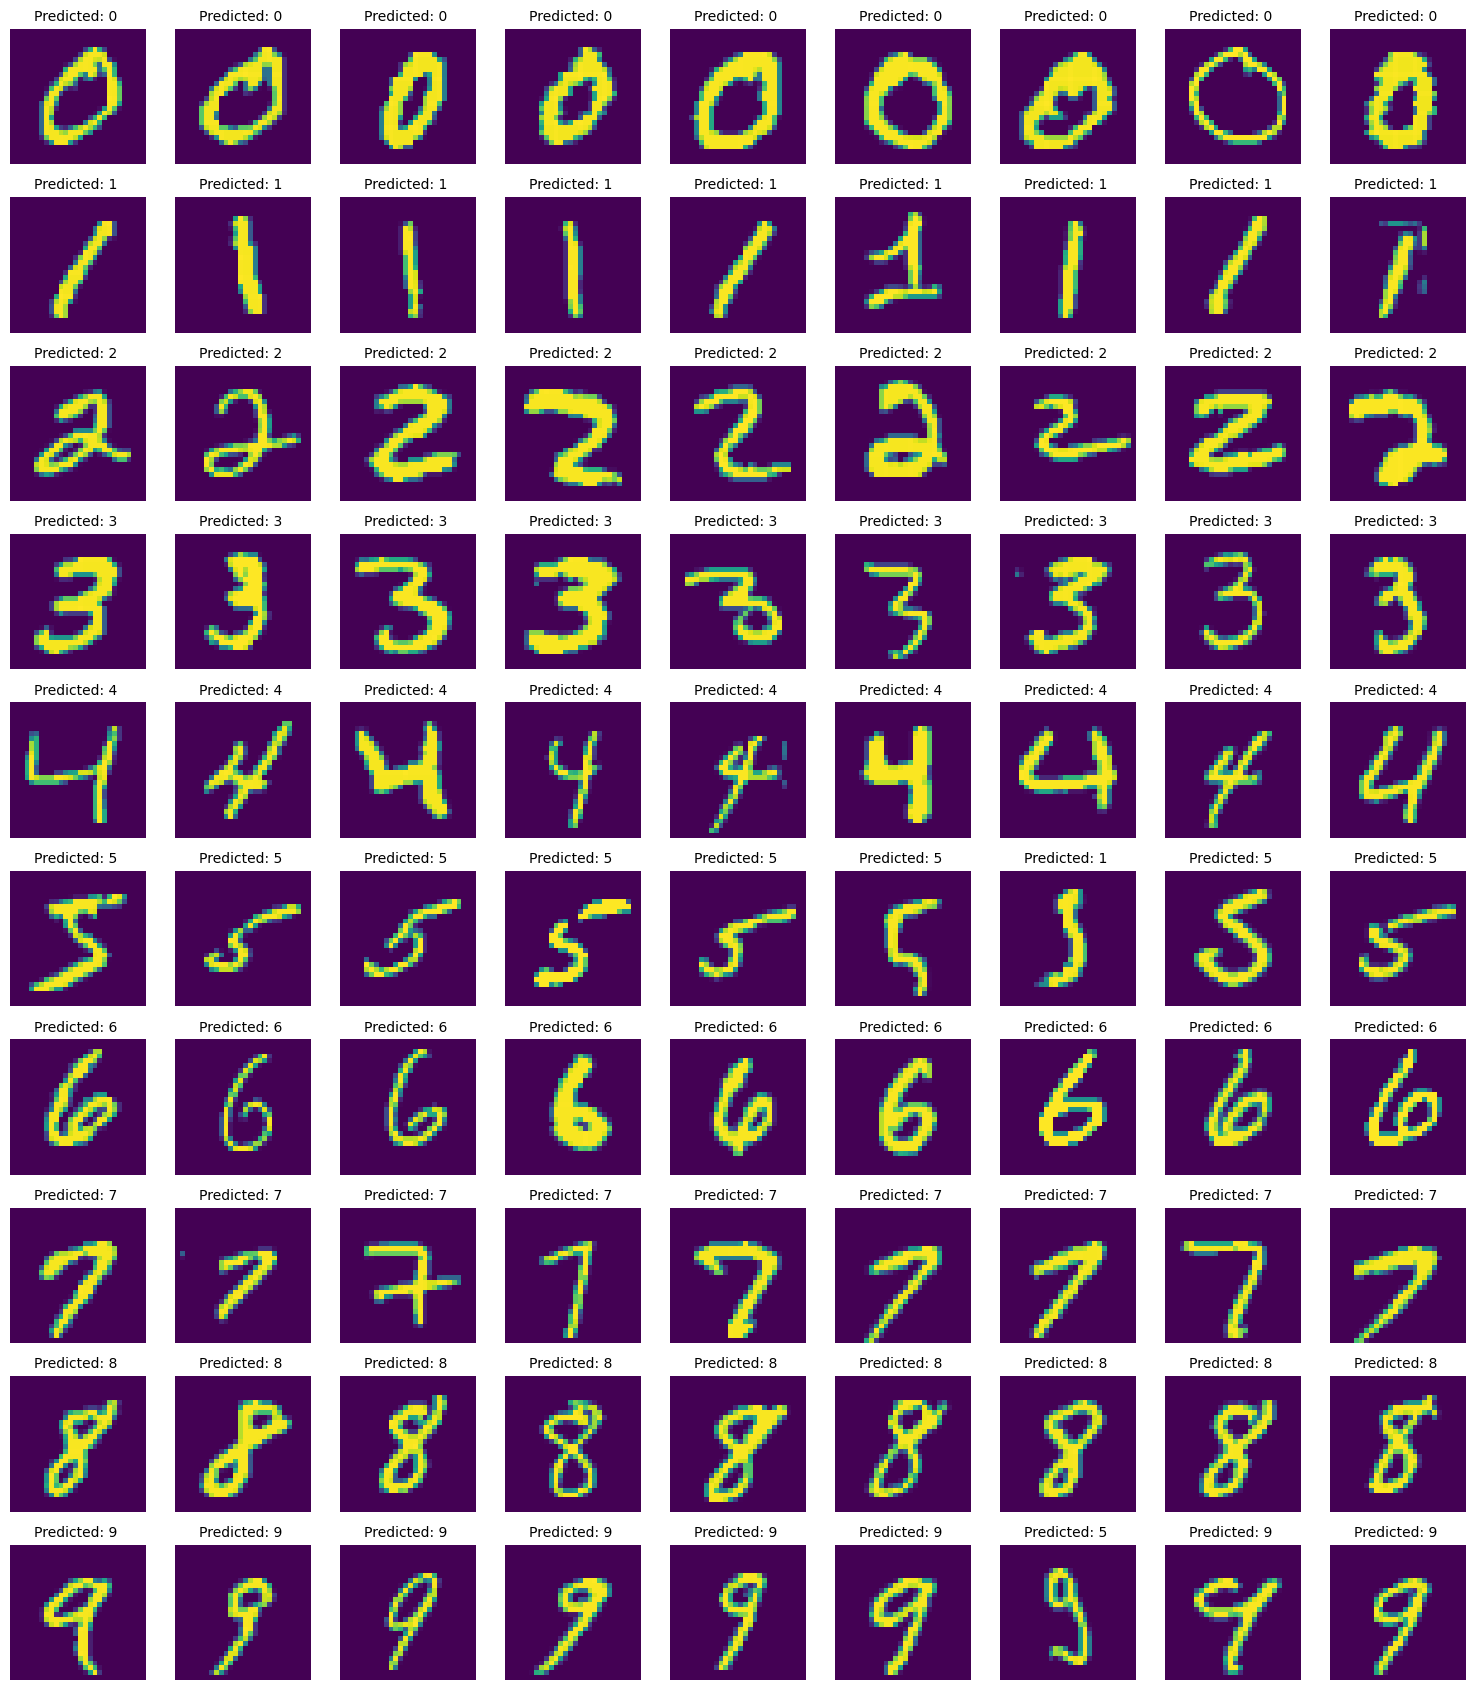

In [16]:
plot_images_grid(batch_imgs)  # function for plotting every number, before adding noise

Iteration 100 final batch loss: 0.0
Final prediction tensor(1, device='cuda:0')
Iteration 100 final batch loss: 1.9073468138230965e-06
Final prediction tensor(2, device='cuda:0')
Iteration 100 final batch loss: 6.079655122448457e-06
Final prediction tensor(3, device='cuda:0')
Iteration 100 final batch loss: 0.0
Final prediction tensor(4, device='cuda:0')
Iteration 100 final batch loss: 0.0
Final prediction tensor(5, device='cuda:0')
Iteration 100 final batch loss: 0.0
Final prediction tensor(6, device='cuda:0')
Iteration 100 final batch loss: 0.0
Final prediction tensor(7, device='cuda:0')
Iteration 100 final batch loss: 0.0
Final prediction tensor(8, device='cuda:0')
Iteration 100 final batch loss: 1.1920928244535389e-07
Final prediction tensor(9, device='cuda:0')
Iteration 100 final batch loss: 0.0
Final prediction tensor(0, device='cuda:0')
Iteration 100 final batch loss: 0.0
Final prediction tensor(2, device='cuda:0')
Iteration 100 final batch loss: 5.125986263010418e-06
Final pred

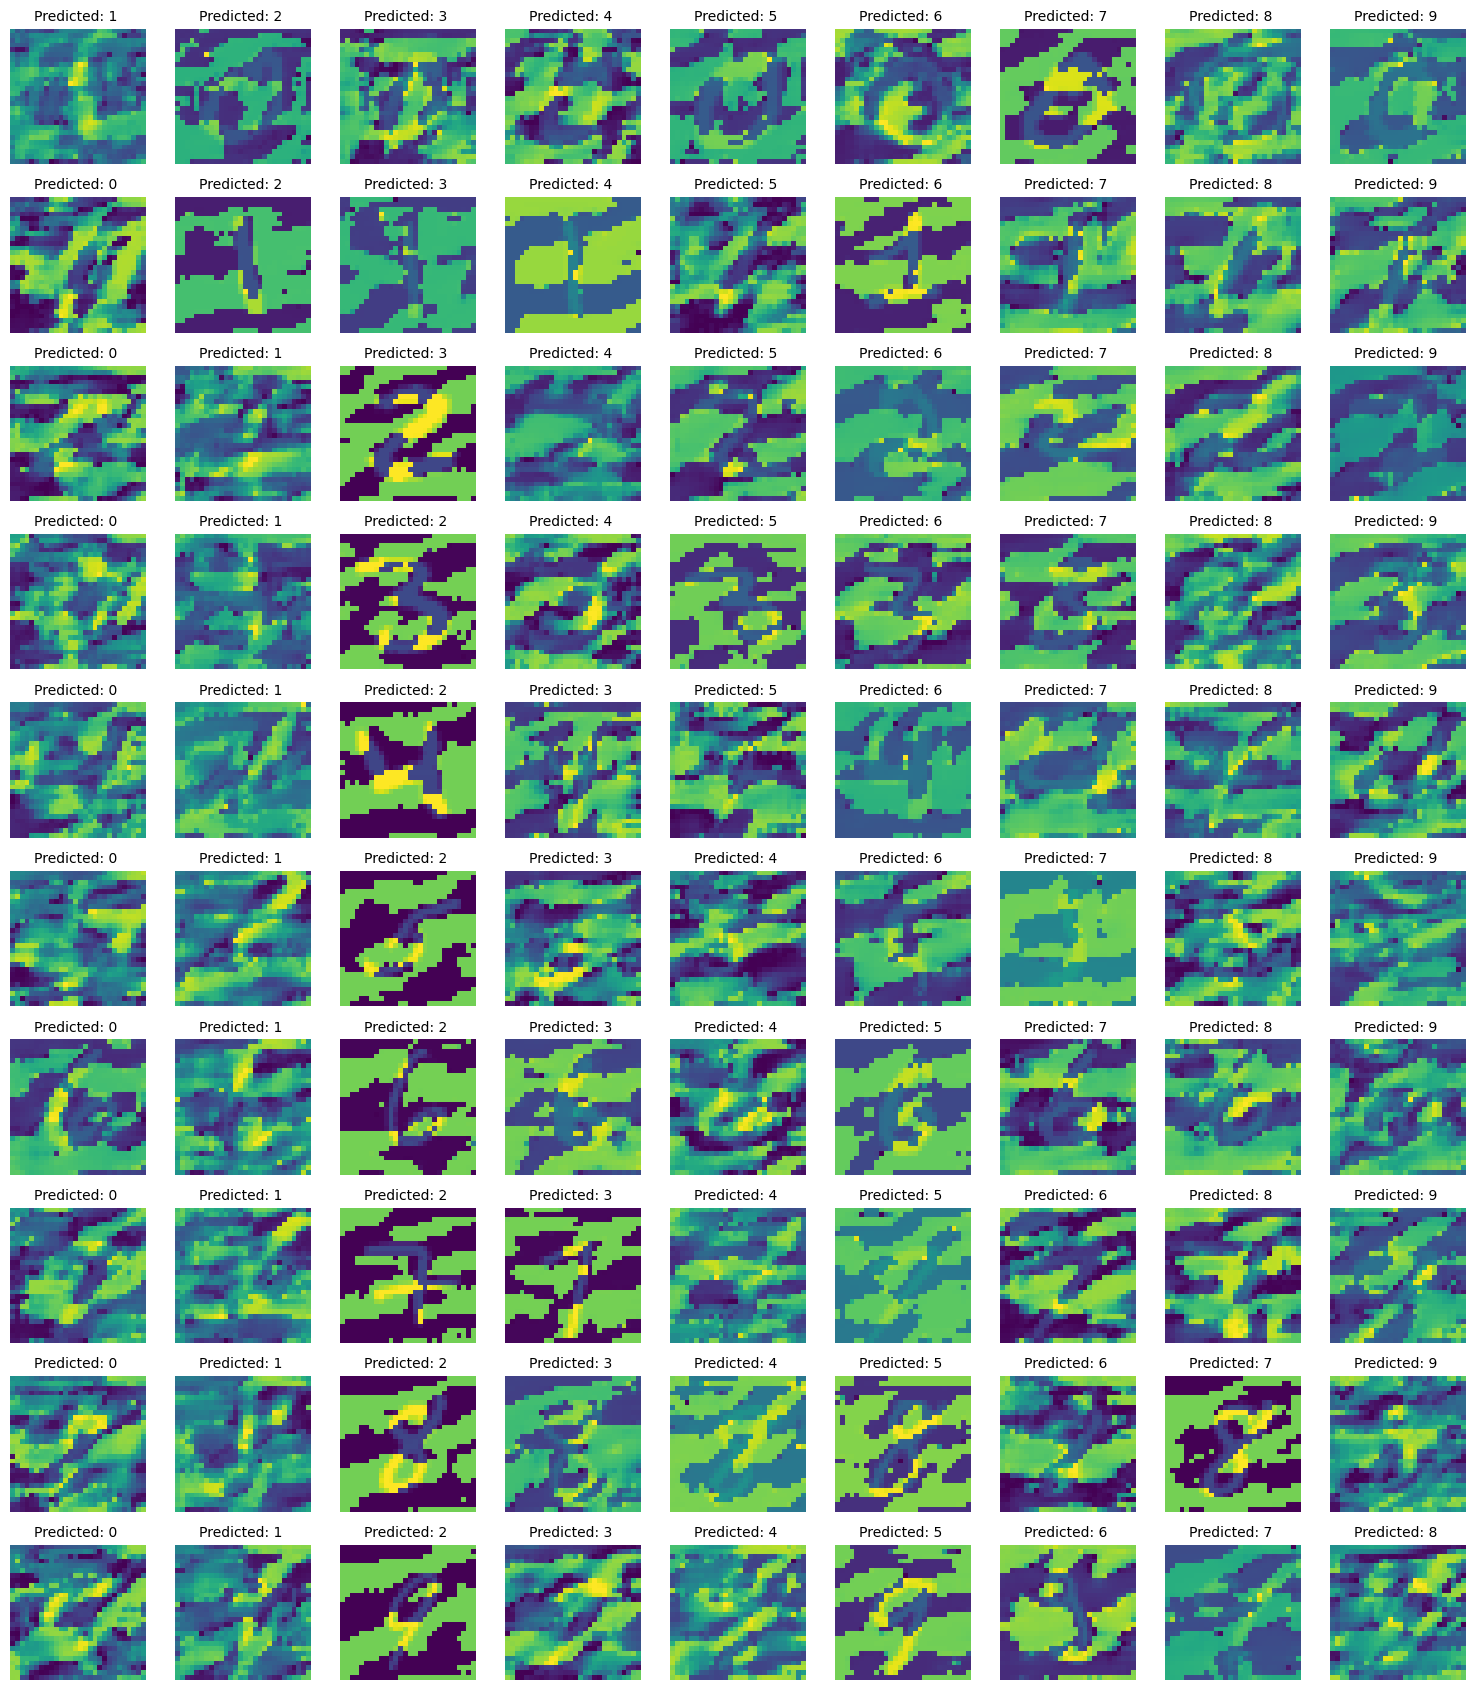

In [19]:
imgs_1 = []
for i in range(90):
    img = train_noise(net, batch_imgs[i], batch_labels[i],
                      lambda_l2=0, info=-1, lr=1, max_iter=100)

    imgs_1.append(img)

plot_images_grid(imgs_1)

Iteration 100 final batch loss: 0.39969733357429504
Final prediction tensor(1, device='cuda:0')
Iteration 100 final batch loss: 0.17746898531913757
Final prediction tensor(2, device='cuda:0')
Iteration 100 final batch loss: 0.13516271114349365
Final prediction tensor(3, device='cuda:0')
Iteration 100 final batch loss: 0.21593187749385834
Final prediction tensor(4, device='cuda:0')
Iteration 100 final batch loss: 0.16704151034355164
Final prediction tensor(5, device='cuda:0')
Iteration 100 final batch loss: 0.31486326456069946
Final prediction tensor(6, device='cuda:0')
Iteration 100 final batch loss: 0.16911832988262177
Final prediction tensor(7, device='cuda:0')
Iteration 100 final batch loss: 0.13587984442710876
Final prediction tensor(8, device='cuda:0')
Iteration 100 final batch loss: 0.10446909070014954
Final prediction tensor(9, device='cuda:0')
Iteration 100 final batch loss: 0.15051627159118652
Final prediction tensor(0, device='cuda:0')
Iteration 100 final batch loss: 0.118419

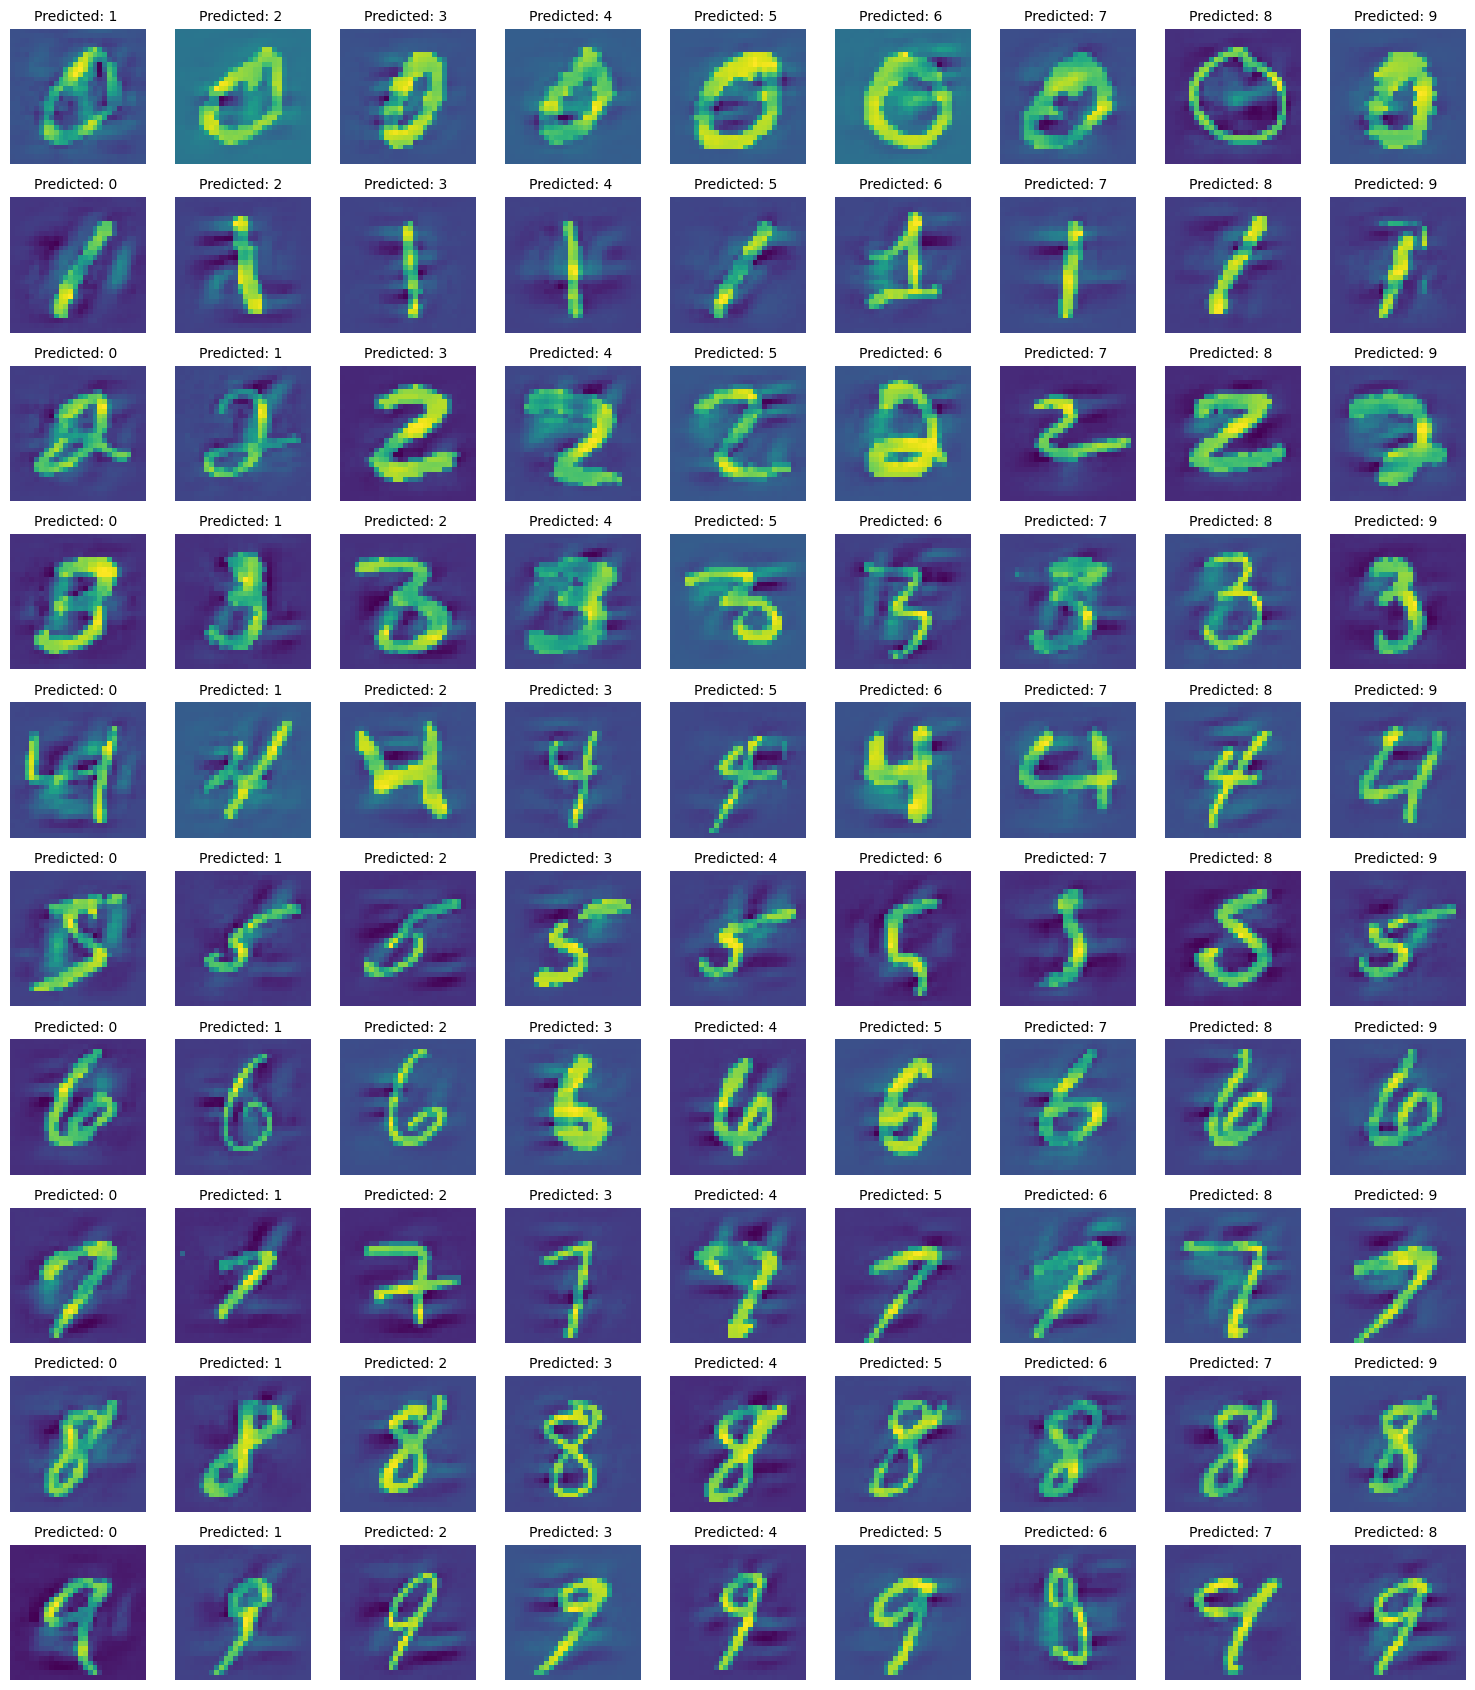

In [21]:
imgs_2 = []
for i in range(90):
    img = train_noise(net, batch_imgs[i], batch_labels[i],
                      lambda_l2=1, info=-1, lr=1, max_iter=100)

    imgs_2.append(img)

plot_images_grid(imgs_2)

Iteration 100 final batch loss: 2.9444658756256104
Final prediction tensor(1, device='cuda:0')
Iteration 100 final batch loss: 1.3447141647338867
Final prediction tensor(2, device='cuda:0')
Iteration 100 final batch loss: 1.366532802581787
Final prediction tensor(3, device='cuda:0')
Iteration 100 final batch loss: 1.8370972871780396
Final prediction tensor(4, device='cuda:0')
Iteration 100 final batch loss: 1.3616032600402832
Final prediction tensor(5, device='cuda:0')
Iteration 100 final batch loss: 2.4594695568084717
Final prediction tensor(6, device='cuda:0')
Iteration 100 final batch loss: 1.253406047821045
Final prediction tensor(7, device='cuda:0')
Iteration 100 final batch loss: 1.0207664966583252
Final prediction tensor(8, device='cuda:0')
Iteration 100 final batch loss: 0.795454204082489
Final prediction tensor(9, device='cuda:0')
Iteration 100 final batch loss: 1.0699673891067505
Final prediction tensor(0, device='cuda:0')
Iteration 100 final batch loss: 0.8708688020706177
Fi

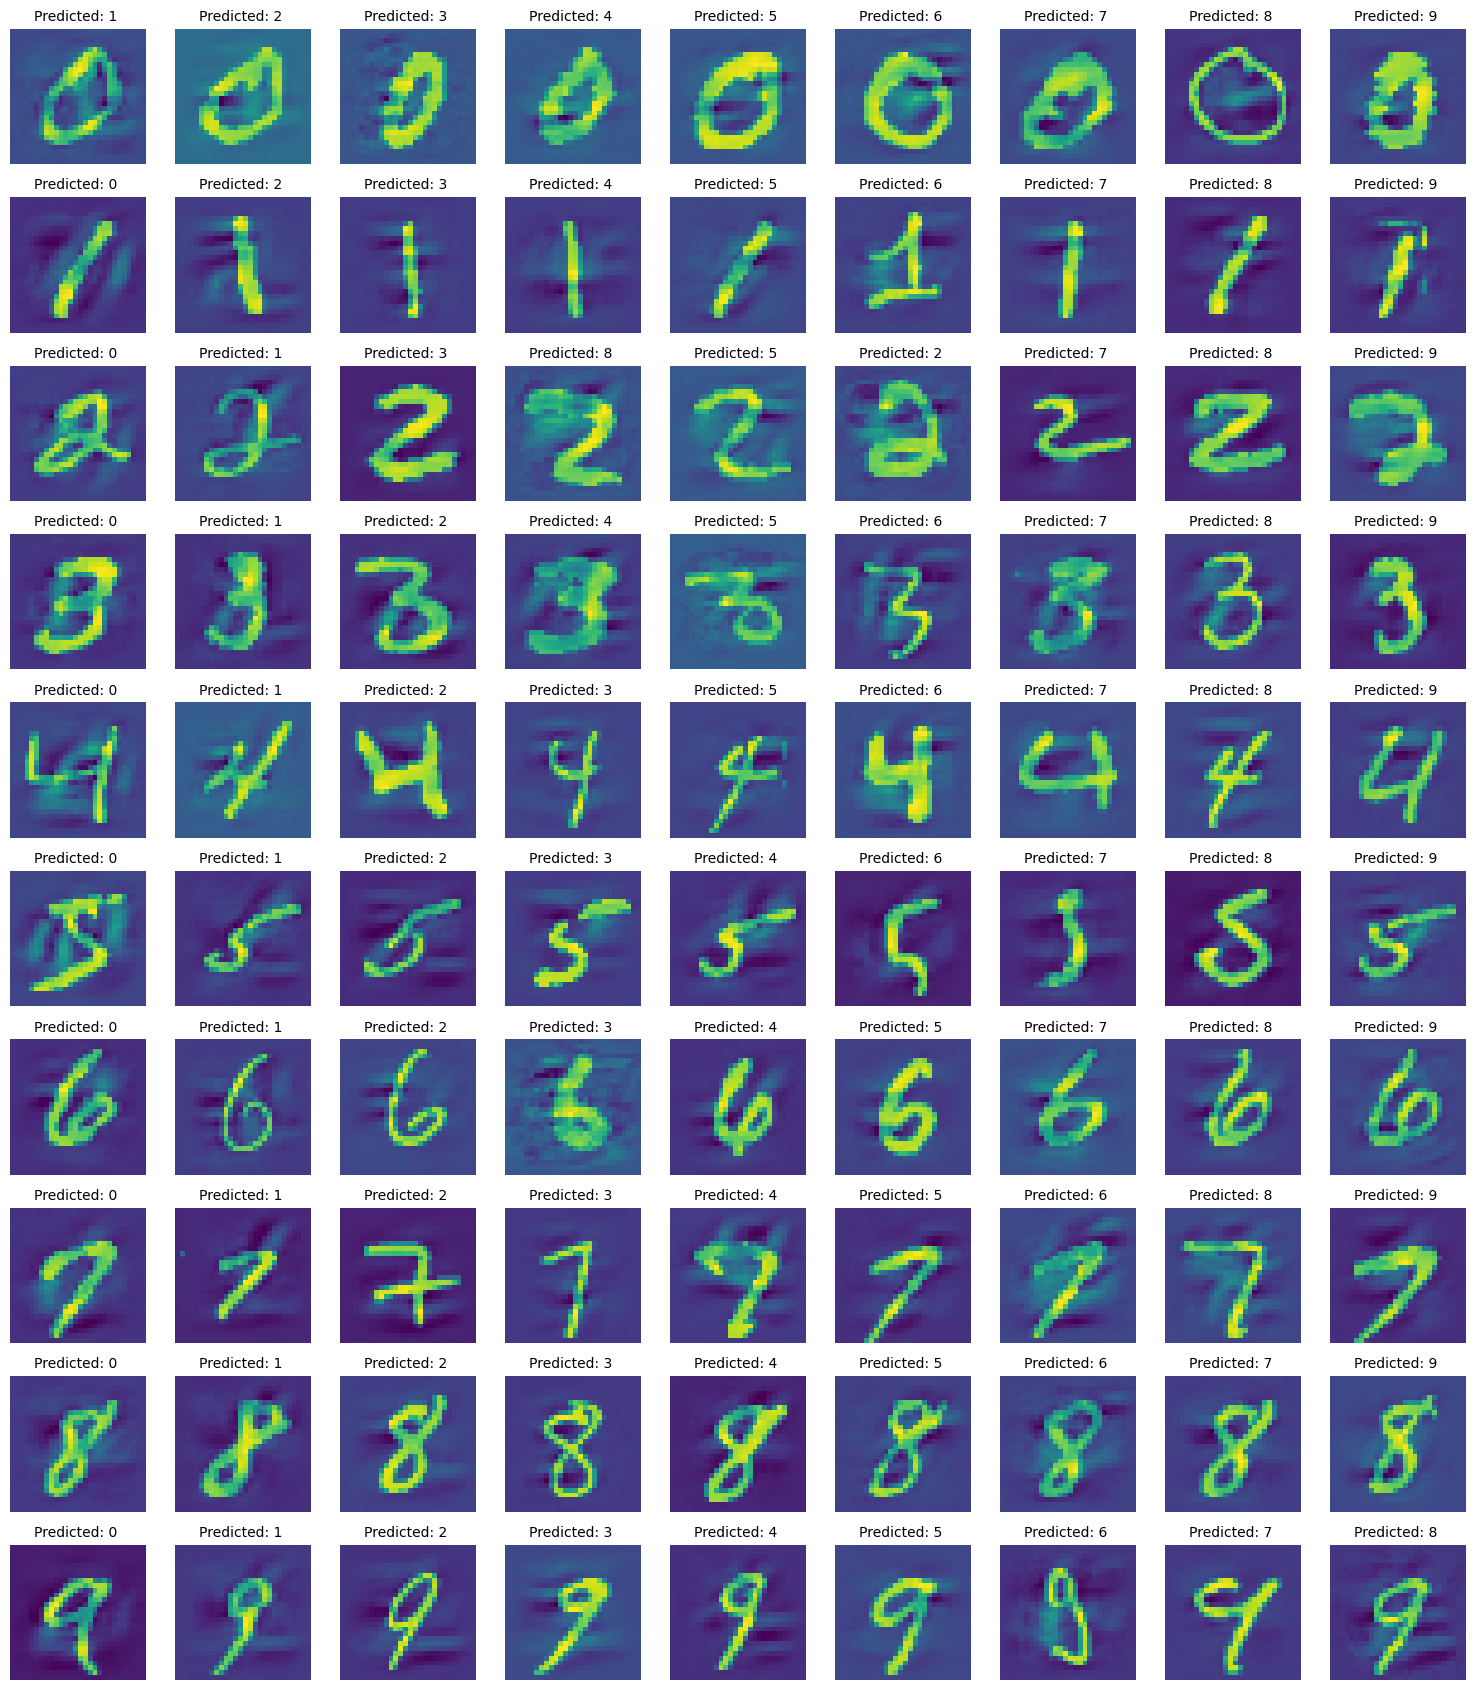

In [22]:
imgs_3 = []
for i in range(90):
    img = train_noise(net, batch_imgs[i], batch_labels[i],
                      lambda_l2=10, info=-1, lr=1, max_iter=100)

    imgs_3.append(img)

plot_images_grid(imgs_3)

Iteration 100 final batch loss: 13.555314064025879
Final prediction tensor(0, device='cuda:0')
Iteration 100 final batch loss: 8.382580757141113
Final prediction tensor(0, device='cuda:0')
Iteration 100 final batch loss: 8.552471160888672
Final prediction tensor(0, device='cuda:0')
Iteration 100 final batch loss: 11.684328079223633
Final prediction tensor(0, device='cuda:0')
Iteration 100 final batch loss: 10.424403190612793
Final prediction tensor(0, device='cuda:0')
Iteration 100 final batch loss: 13.9066743850708
Final prediction tensor(0, device='cuda:0')
Iteration 100 final batch loss: 7.907294273376465
Final prediction tensor(0, device='cuda:0')
Iteration 100 final batch loss: 6.414133071899414
Final prediction tensor(0, device='cuda:0')
Iteration 100 final batch loss: 5.860838890075684
Final prediction tensor(0, device='cuda:0')
Iteration 100 final batch loss: 7.073779106140137
Final prediction tensor(1, device='cuda:0')
Iteration 100 final batch loss: 5.780268669128418
Final pr

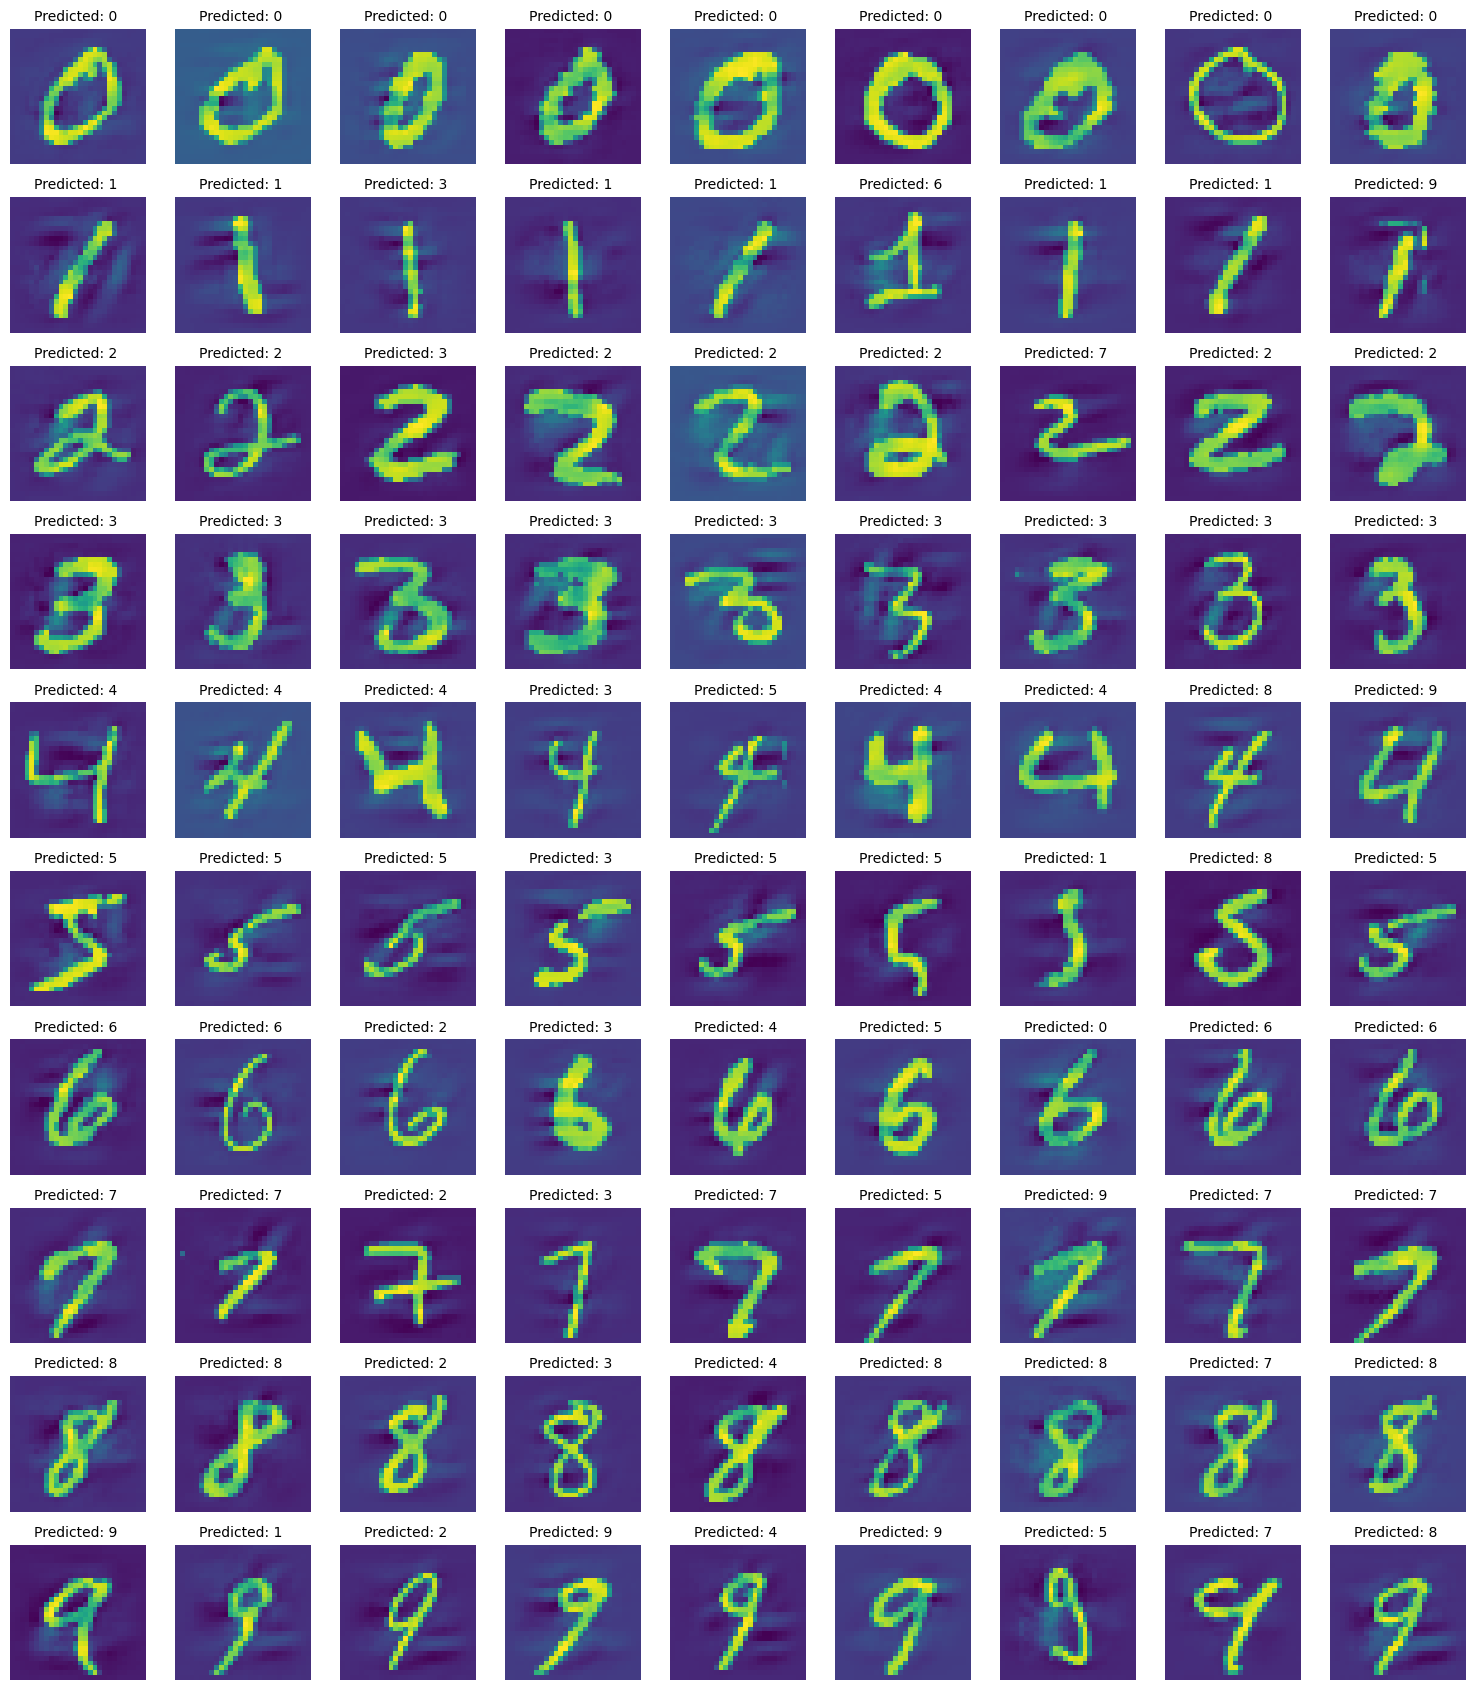

In [23]:
imgs_4 = []
for i in range(90):
    img = train_noise(net, batch_imgs[i], batch_labels[i],
                      lambda_l2=100, info=-1, lr=1, max_iter=100)

    imgs_4.append(img)

plot_images_grid(imgs_4)

# Conclusions for task 2
- to
- be
- added